# **Setlist Prediction using Multi Label Classification**

---

**Created by:** [Glen Valencius](https://github.com/glenvj-j)

This project aims to predict the potential setlist for future **BABYMETAL** concerts using historical concert data collected from [setlist.fm](https://www.setlist.fm/setlists/babymetal-5bd19f80.html).  

Leveraging a multi-label classification model, we estimate the likelihood of each song appearing in a given concert's setlist based on contextual factors like location, time, and album releases.


**🎯 Objective**  
To forecast the songs most likely to be performed at an upcoming BABYMETAL concert.


**📊 Model Insights**  
- **Average songs per concert:** 9  
- **New album tracks per setlist:** Typically 2–3 songs  
- **Prediction method:** Multi-label classification


**✅ Evaluation Metrics**  
1. **Micro-Precision**  
   Focuses on minimizing **false positives** — to avoid predicting songs that won’t actually be played.  
2. **Hamming Loss**  
   Measures the fraction of incorrect labels — **lower is better**.


**📅 Dataset Coverage**  
Concert data from **November 28, 2010** to **May 13, 2025**.


In [2043]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)


In [ ]:
df = pd.read_csv('dataset/Babymetal_concert_dataset.csv')
df = df.iloc[::-1].reset_index(drop=['index'])
df.tail()

,id,versionId,eventDate,lastUpdated,url,artist.mbid,artist.name,artist.sortName,artist.disambiguation,artist.url,venue.id,venue.name,venue.city.id,venue.city.name,venue.city.state,venue.city.stateCode,venue.city.coords.lat,venue.city.coords.long,venue.city.country.code,venue.city.country.name,venue.url,tour.name,sets.set,info,song,4 no Uta,Akatsuki,Akumu no Rondo,Amore -Sousei-,Arkadia,Awadama Fever,BABYMETAL DEATH,Believing,Brand New Day,Breaking the Law,BxMxC,Catch Me If You Can,Chokotto Love,DA DA DANCE,Distortion,Divine Attack - Shingeki -,Doki Doki ☆ Morning,Doki Doki ☆ Morning / Iine!,Elevator Girl,Episode II Intro Video,FUTURE METAL,From Dusk Till Dawn,GJ!,Gimme Chocolate!!,Headbangeeeeerrrrr!!!!!,IN THE NAME OF,Iine!,"Ijime, Dame, Zettai",Intro Video,KARATE,Kagerou,Kimi to Anime ga Mitai~Answer for Animation With You,Kon! Kon!,LOVE Machine,Light and Darkness,MAYA,META! Meta Taro,METAL KINGDOM,METALI!!,METALIZM,Megitsune,Mirror Mirror,Mischiefs of Metal Gods,Monochrome,"NO RAIN, NO RAINBOW",Night Night Burn!,Oh! MAJINAI,Onedari Daisakusen,Over The Future,PA PA YA!!,Painkiller,Painkiller / Breaking the Law,RATATATA,Revolutionary Étude,Road of Resistance,Shanti Shanti Shanti,Shine,Sis. Anger,Song 3,Starlight,Syncopation,THE LEGEND,THE ONE,Tales of The Destinies,Tamashii no Refrain,The Hill of Wisteria,Time Wave,Uki Uki ★ Midnight,Video,White Love,YAVA!,festival
467,1b5d795c,g3345f03d,06-03-2025,2025-03-06T11:40:49.484+0000,https://www.setlist.fm/setlist/babymetal/2025/...,27e2997f-f7a1-4353-bcc4-57b9274fa9a4,BABYMETAL,BABYMETAL,NaN,https://www.setlist.fm/setlists/babymetal-5bd1...,53d6370d,Enmore Theatre,2147714,Sydney,New South Wales,NSW,-33.86785,151.207323,AU,Australia,https://www.setlist.fm/venue/enmore-theatre-sy...,BABYMETAL WORLD TOUR 2025,"[{'song': [{'name': 'BABYMETAL DEATH'}, {'name...",NaN,"['BABYMETAL DEATH', 'Distortion', 'DA DA DANCE...",0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False
468,73500e85,g5b453bf0,08-03-2025,2025-03-08T08:30:47.113+0000,https://www.setlist.fm/setlist/babymetal/2025/...,27e2997f-f7a1-4353-bcc4-57b9274fa9a4,BABYMETAL,BABYMETAL,NaN,https://www.setlist.fm/setlists/babymetal-5bd1...,13d63d41,Centennial Park,2147714,Sydney,New South Wales,NSW,-33.86785,151.207323,AU,Australia,https://www.setlist.fm/venue/centennial-park-s...,BABYMETAL WORLD TOUR 2025,"[{'song': [{'name': 'BABYMETAL DEATH'}, {'name...",NaN,"['BABYMETAL DEATH', 'Distortion', 'PA PA YA!!'...",0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
469,2351a887,g7b4d6254,10-05-2025,2025-05-12T20:03:14.757+0000,https://www.setlist.fm/setlist/babymetal/2025/...,27e2997f-f7a1-4353-bcc4-57b9274fa9a4,BABYMETAL,BABYMETAL,NaN,https://www.setlist.fm/setlists/babymetal-5bd1...,13d22139,Vorst Nationaal / Forest National,2798139,Vorst / Forest,Brussels-Capital Region,BE-BRU,50.80000,4.317000,BE,Belgium,https://www.setlist.fm/venue/vorst-nationaal-f...,BABYMETAL UK & EUROPE ARENA TOUR 2025,"[{'song': [{'name': 'BABYMETAL DEATH'}, {'name...",NaN,"['BABYMETAL DEATH', 'Megitsune', 'PA PA YA!!',...",0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,False
470,2b51a886,g6b4d62ce,12-05-2025,2025-05-12T20:36:36.937+0000,https://www.setlist.fm/setlist/babymetal/2025/...,27e2997f-f7a1-4353-bcc4-57b9274fa9a4,BABYMETAL,BABYMETAL,NaN,https://www.setlist.fm/setlists/babymetal-5bd1...,2bd02c8e,Barclays Arena,2911298,Hamburg,Hamburg,04,53.55000,10.000000,DE,Germany,https://www.setlist.fm/venue/barclays-arena-ha...,BABYMETAL UK & EUROPE ARENA TOUR 2025,"[{'song': [{'name': 'BABYMETAL DEATH'}, {'name...",NaN,"['BABYMETAL DEATH', 'Megitsune', 'PA PA YA!!',...",0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,

# **1. Planning**

## Splitting Feature and Target

for easier to read, we will split the Feature and Target

at the end we will combine it again

In [2045]:
df_feature = df[['eventDate','venue.name','venue.city.name','venue.city.country.name','tour.name','festival']]
df_feature['eventDate'] = pd.to_datetime(df_feature['eventDate'])
feature_duplicate = df_feature[df_feature.duplicated()].index
df_feature = df_feature.drop_duplicates()
df_feature = df_feature.rename(columns={'venue.name':'venue','venue.city.name':'city','venue.city.country.name':'country','tour.name':'tour_name'})
df_feature

,eventDate,venue,city,country,tour_name,festival
0,2010-11-28,Yokohama Akarenga Sōko 1-Gōkan,Yokohama,Japan,NaN,False
2,2010-12-14,Stage One,Tokyo,Japan,NaN,False
3,2011-02-12,ASTRO HALL,Tokyo,Japan,NaN,False
4,2011-05-01,Tower Records Shinjuku,Tokyo,Japan,NaN,False
5,2011-05-01,Stage One,Tokyo,Japan,NaN,False
...,...,...,...,...,...,...
467,2025-03-06,Enmore Theatre,Sydney,Australia,BABYMETAL WORLD TOUR 2025,False
468,2025-03-08,Centennial Park,Sydney,Australia,BABYMETAL WORLD TOUR 2025,True
469,2025-05-10,Vorst Nationaal / Forest National,Vorst / Forest,Belgium,BABYMETAL UK & EUROPE ARENA TOUR 2025,False
470,2025-05-12,Barclays Arena,Hamburg,Germany,BABYMETAL UK & EUROPE ARENA TOUR 2025,False


In [2046]:
df_target = df.loc[:,'4 no Uta':'YAVA!']
df_target = df_target.drop(feature_duplicate)
df_target

,4 no Uta,Akatsuki,Akumu no Rondo,Amore -Sousei-,Arkadia,Awadama Fever,BABYMETAL DEATH,Believing,Brand New Day,Breaking the Law,BxMxC,Catch Me If You Can,Chokotto Love,DA DA DANCE,Distortion,Divine Attack - Shingeki -,Doki Doki ☆ Morning,Doki Doki ☆ Morning / Iine!,Elevator Girl,Episode II Intro Video,FUTURE METAL,From Dusk Till Dawn,GJ!,Gimme Chocolate!!,Headbangeeeeerrrrr!!!!!,IN THE NAME OF,Iine!,"Ijime, Dame, Zettai",Intro Video,KARATE,Kagerou,Kimi to Anime ga Mitai~Answer for Animation With You,Kon! Kon!,LOVE Machine,Light and Darkness,MAYA,META! Meta Taro,METAL KINGDOM,METALI!!,METALIZM,Megitsune,Mirror Mirror,Mischiefs of Metal Gods,Monochrome,"NO RAIN, NO RAINBOW",Night Night Burn!,Oh! MAJINAI,Onedari Daisakusen,Over The Future,PA PA YA!!,Painkiller,Painkiller / Breaking the Law,RATATATA,Revolutionary Étude,Road of Resistance,Shanti Shanti Shanti,Shine,Sis. Anger,Song 3,Starlight,Syncopation,THE LEGEND,THE ONE,Tales of The Destinies,Tamashii no Refrain,The Hill of Wisteria,Time Wave,Uki Uki ★ Midnight,Video,White Love,YAVA!
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
468,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
469,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
470,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Feature Enginering

### Days Since Last Concert

In [2047]:
df_feature['days_since_last_concert'] = df_feature['eventDate'].diff().dt.days
df_feature

,eventDate,venue,city,country,tour_name,festival,days_since_last_concert
0,2010-11-28,Yokohama Akarenga Sōko 1-Gōkan,Yokohama,Japan,NaN,False,NaN
2,2010-12-14,Stage One,Tokyo,Japan,NaN,False,16.0
3,2011-02-12,ASTRO HALL,Tokyo,Japan,NaN,False,60.0
4,2011-05-01,Tower Records Shinjuku,Tokyo,Japan,NaN,False,78.0
5,2011-05-01,Stage One,Tokyo,Japan,NaN,False,0.0
...,...,...,...,...,...,...,...
467,2025-03-06,Enmore Theatre,Sydney,Australia,BABYMETAL WORLD TOUR 2025,False,2.0
468,2025-03-08,Centennial Park,Sydney,Australia,BABYMETAL WORLD TOUR 2025,True,2.0
469,2025-05-10,Vorst Nationaal / Forest National,Vorst / Forest,Belgium,BABYMETAL UK & EUROPE ARENA TOUR 2025,False,63.0
470,2025-05-12,Barclays Arena,Hamburg,Germany,BABYMETAL UK & EUROPE ARENA TOUR 2025,False,2.0


### New Album

add new album, flag a tour that in the same time as album release

- Babymetal : 26 Feb 2014
- Metal Resistance : 29 March 2016
- Metal Galaxy : 8 Okt 2019
- The Other One : 24 March 2023

In [2048]:
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2025-05-23


In [2049]:
album = pd.DataFrame({
    'Album Name' : ['BABYMETAL','Metal Resistance','Metal Galaxy','The Other One'],
    'Release' : ['26-02-2014','29-03-2016','08-10-2019','24-03-2023']}
)
album['Last'] = album['Release'].shift(-1)
album['Last'].fillna('27-06-2025',inplace=True)
album

,Album Name,Release,Last
0,BABYMETAL,26-02-2014,29-03-2016
1,Metal Resistance,29-03-2016,08-10-2019
2,Metal Galaxy,08-10-2019,24-03-2023
3,The Other One,24-03-2023,27-06-2025


In [2050]:
df_feature['new_album'] = False
df_feature

,eventDate,venue,city,country,tour_name,festival,days_since_last_concert,new_album
0,2010-11-28,Yokohama Akarenga Sōko 1-Gōkan,Yokohama,Japan,NaN,False,NaN,False
2,2010-12-14,Stage One,Tokyo,Japan,NaN,False,16.0,False
3,2011-02-12,ASTRO HALL,Tokyo,Japan,NaN,False,60.0,False
4,2011-05-01,Tower Records Shinjuku,Tokyo,Japan,NaN,False,78.0,False
5,2011-05-01,Stage One,Tokyo,Japan,NaN,False,0.0,False
...,...,...,...,...,...,...,...,...
467,2025-03-06,Enmore Theatre,Sydney,Australia,BABYMETAL WORLD TOUR 2025,False,2.0,False
468,2025-03-08,Centennial Park,Sydney,Australia,BABYMETAL WORLD TOUR 2025,True,2.0,False
469,2025-05-10,Vorst Nationaal / Forest National,Vorst / Forest,Belgium,BABYMETAL UK & EUROPE ARENA TOUR 2025,False,63.0,False
470,2025-05-12,Barclays Arena,Hamburg,Germany,BABYMETAL UK & EUROPE ARENA TOUR 2025,False,2.0,False


### Date Related

In [2051]:
df_feature['month'] = df_feature['eventDate'].dt.month
df_feature['year'] = df_feature['eventDate'].dt.year

### New Album

We will flag a concert that run after an Album Release

In [2052]:
int(album.iloc[0]['Release'][-4:])

2014

In [2053]:
album

,Album Name,Release,Last
0,BABYMETAL,26-02-2014,29-03-2016
1,Metal Resistance,29-03-2016,08-10-2019
2,Metal Galaxy,08-10-2019,24-03-2023
3,The Other One,24-03-2023,27-06-2025


In [2054]:
int(album.iloc[2]['Release'][-4:])+1

2020

In [2055]:
concert_first_album = []
for x in range(album.shape[0]):
    if x == 0 or x == 1:
        concert = df_feature.loc[(df_feature['year']==int(album.iloc[x]['Release'][-4:]))&(df_feature['month']>int(album.iloc[x]['Release'][3:5]))]['tour_name'].unique()
        concert = [name for name in concert if not pd.isna(name)]
        concert_first_album.append(concert)
    else :
        concert = df_feature.loc[(df_feature['year']==int(album.iloc[x]['Release'][-4:]))|(df_feature['year']==int(album.iloc[x]['Release'][-4:])+1)]['tour_name'].unique()
        concert = [name for name in concert if not pd.isna(name)]
        concert_first_album.append(concert)       
concert_first_album_flatten = [y for x in concert_first_album for y in x]
concert_first_album_flatten

['KUROI YORU LEGEND "DOOMSDAY" ~SHOUKAN NO GI~',
 'APOCRYPHA',
 'BABYMETAL WORLD TOUR 2014',
 'Back to the USA/UK Tour 2014',
 'BABYMETAL WORLD TOUR 2016',
 'APOCRYPHA - Only The FOX GOD Knows -',
 'APOCRYPHA -THE WHITE MASS-',
 'BABYMETAL WORLD TOUR 2016 LEGEND -METAL RESISTANCE-',
 'BABYMETAL AWAKENS -THE SUN ALSO RISES-',
 'BABYMETAL ARISES -BEYOND THE MOON- LEGEND -M-',
 'METAL GALAXY WORLD TOUR / U.S.A. 2019',
 'METAL GALAXY WORLD TOUR IN JAPAN',
 'APOCRYPHA - ANOTHER GALAXY -',
 'METAL GALAXY WORLD TOUR IN JAPAN EXTRA SHOW / LEGEND - METAL GALAXY',
 'METAL GALAXY WORLD TOUR / EUROPE 2020',
 'BABYMETAL RETURNS - THE OTHER ONE -',
 'BABYMETAL BEGINS - THE OTHER ONE -',
 'BABYMETAL WORLD TOUR 2023',
 'APOCRYPHA - ANOTHER ONE -',
 'THE BABYKLOK TOUR 2023',
 'BABYMETAL WORLD TOUR 2023-2024 LEGEND - MM',
 'BABYMETAL WORLD TOUR 2023-2024 TOUR FINAL IN JAPAN LEGEND - 43',
 'THE BABYKLOK TOUR 2024',
 'BABYMETAL WORLD TOUR 2024']

In [2056]:
df_feature.loc[df_feature['tour_name'].isin(concert_first_album_flatten),'new_album']=True

In [2057]:
df_feature['new_album'].value_counts()

new_album
False    240
True     222
Name: count, dtype: int64

In [2058]:
df_feature

,eventDate,venue,city,country,tour_name,festival,days_since_last_concert,new_album,month,year
0,2010-11-28,Yokohama Akarenga Sōko 1-Gōkan,Yokohama,Japan,NaN,False,NaN,False,11,2010
2,2010-12-14,Stage One,Tokyo,Japan,NaN,False,16.0,False,12,2010
3,2011-02-12,ASTRO HALL,Tokyo,Japan,NaN,False,60.0,False,2,2011
4,2011-05-01,Tower Records Shinjuku,Tokyo,Japan,NaN,False,78.0,False,5,2011
5,2011-05-01,Stage One,Tokyo,Japan,NaN,False,0.0,False,5,2011
...,...,...,...,...,...,...,...,...,...,...
467,2025-03-06,Enmore Theatre,Sydney,Australia,BABYMETAL WORLD TOUR 2025,False,2.0,False,3,2025
468,2025-03-08,Centennial Park,Sydney,Australia,BABYMETAL WORLD TOUR 2025,True,2.0,False,3,2025
469,2025-05-10,Vorst Nationaal / Forest National,Vorst / Forest,Belgium,BABYMETAL UK & EUROPE ARENA TOUR 2025,False,63.0,False,5,2025
470,2025-05-12,Barclays Arena,Hamburg,Germany,BABYMETAL UK & EUROPE ARENA TOUR 2025,False,2.0,False,5,2025


### Days Since New Album

In [2059]:
df_feature['days_since_new_album'] = 0
df_feature.head()

,eventDate,venue,city,country,tour_name,festival,days_since_last_concert,new_album,month,year,days_since_new_album
0,2010-11-28,Yokohama Akarenga Sōko 1-Gōkan,Yokohama,Japan,NaN,False,NaN,False,11,2010,0
2,2010-12-14,Stage One,Tokyo,Japan,NaN,False,16.0,False,12,2010,0
3,2011-02-12,ASTRO HALL,Tokyo,Japan,NaN,False,60.0,False,2,2011,0
4,2011-05-01,Tower Records Shinjuku,Tokyo,Japan,NaN,False,78.0,False,5,2011,0
5,2011-05-01,Stage One,Tokyo,Japan,NaN,False,0.0,False,5,2011,0


In [2060]:
album

,Album Name,Release,Last
0,BABYMETAL,26-02-2014,29-03-2016
1,Metal Resistance,29-03-2016,08-10-2019
2,Metal Galaxy,08-10-2019,24-03-2023
3,The Other One,24-03-2023,27-06-2025


In [2061]:
for x in range(album.shape[0]):
    release = df_feature['eventDate']>album.iloc[x]['Release']
    last = df_feature['eventDate']<album.iloc[x]['Last']
    df_feature.loc[release&last]['eventDate'].rank()
    df_feature.loc[release&last,'days_since_new_album'] = df_feature.loc[release&last]['eventDate'].rank()

## **Cleaning Filling NaN**

In [2062]:
df = pd.concat([df_feature,df_target],axis=1)
df

,eventDate,venue,city,country,tour_name,festival,days_since_last_concert,new_album,month,year,days_since_new_album,4 no Uta,Akatsuki,Akumu no Rondo,Amore -Sousei-,Arkadia,Awadama Fever,BABYMETAL DEATH,Believing,Brand New Day,Breaking the Law,BxMxC,Catch Me If You Can,Chokotto Love,DA DA DANCE,Distortion,Divine Attack - Shingeki -,Doki Doki ☆ Morning,Doki Doki ☆ Morning / Iine!,Elevator Girl,Episode II Intro Video,FUTURE METAL,From Dusk Till Dawn,GJ!,Gimme Chocolate!!,Headbangeeeeerrrrr!!!!!,IN THE NAME OF,Iine!,"Ijime, Dame, Zettai",Intro Video,KARATE,Kagerou,Kimi to Anime ga Mitai~Answer for Animation With You,Kon! Kon!,LOVE Machine,Light and Darkness,MAYA,META! Meta Taro,METAL KINGDOM,METALI!!,METALIZM,Megitsune,Mirror Mirror,Mischiefs of Metal Gods,Monochrome,"NO RAIN, NO RAINBOW",Night Night Burn!,Oh! MAJINAI,Onedari Daisakusen,Over The Future,PA PA YA!!,Painkiller,Painkiller / Breaking the Law,RATATATA,Revolutionary Étude,Road of Resistance,Shanti Shanti Shanti,Shine,Sis. Anger,Song 3,Starlight,Syncopation,THE LEGEND,THE ONE,Tales of The Destinies,Tamashii no Refrain,The Hill of Wisteria,Time Wave,Uki Uki ★ Midnight,Video,White Love,YAVA!
0,2010-11-28,Yokohama Akarenga Sōko 1-Gōkan,Yokohama,Japan,NaN,False,NaN,False,11,2010,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2010-12-14,Stage One,Tokyo,Japan,NaN,False,16.0,False,12,2010,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2011-02-12,ASTRO HALL,Tokyo,Japan,NaN,False,60.0,False,2,2011,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2011-05-01,Tower Records Shinjuku,Tokyo,Japan,NaN,False,78.0,False,5,2011,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2011-05-01,Stage One,Tokyo,Japan,NaN,False,0.0,False,5,2011,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,2025-03-06,Enmore Theatre,Sydney,Australia,BABYMETAL WORLD TOUR 2025,False,2.0,False,3,2025,150.0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
468,2025-03-08,Centennial Park,Sydney,Australia,BABYMETAL WORLD TOUR 2025,True,2.0,False,3,2025,151.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
469,2025-05-10,Vorst Nationaal / Forest National,Vorst / Forest,Belgium,BABYMETAL UK & EUROPE ARENA TOUR 2025,False,63.0,False,5,2025,152.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
470,2025-05-12,Barclays Arena,Hamburg,Germany,BABYMETAL UK & EUROPE ARENA TOUR 2025,False,2.0,False,5,2025,153.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [2063]:
# Show how much NaN in each column
def check_NaN_total(df):
    percentage_nan = pd.DataFrame({
    'Total NaN': df.isna().sum(),
    'Percentage' : round(df.isna().sum()/df.shape[0]*100)
    })
    print('=============== Total NaN in each column ===============')
    display(percentage_nan.sort_values(by='Percentage',ascending=False))

check_NaN_total(df)

=============== Total NaN in each column ===============


,Total NaN,Percentage
tour_name,137,30.0
eventDate,0,0.0
Mirror Mirror,0,0.0
PA PA YA!!,0,0.0
Over The Future,0,0.0
...,...,...
Doki Doki ☆ Morning,0,0.0
Divine Attack - Shingeki -,0,0.0
Distortion,0,0.0
DA DA DANCE,0,0.0


We will fill the days_since_new_album and days_since_last_concert with 0, it assign that the concert doesn't had new album and last concert

for tour name that doesn't had name will be named Single

In [2064]:
df['days_since_new_album'] = df['days_since_new_album'].fillna(0)
df['days_since_last_concert'] = df['days_since_last_concert'].fillna(0)

df['tour_name'] = df['tour_name'].fillna('Single')

In [2138]:
df.to_csv('dataset/clean_dataset.csv',index=False)

# **2. Analyze**

## **2.1. Average Song per Concert**

In [2065]:
df_analyze = df.copy()
df_analyze['total_song'] = df.loc[:,'4 no Uta':].sum(axis=1)
df_analyze['festival'] = df_analyze['festival'].replace({True: 'Yes', False: 'No'})

print(f'''Average song played on a concert is {int(df_analyze['total_song'].mean())}''')

Average song played on a concert is 9


In [2066]:
import plotly.express as px
df_total_song = df_analyze.groupby('festival')['total_song'].median().reset_index()
fig = px.bar(
    df_total_song,
    x='festival',
    y='total_song',
    color="festival",
    text_auto=True,
    title="Number Songs Played in Festival is Lower than Solo Concert",
    labels={
        'festival': 'Is Festival?',
        'total_song': 'Median Number of Songs'
    }
)


fig.show()


Insight :

The number of songs performed at a festival is typically lower than at a solo concert. 

This is because festivals feature multiple bands sharing the stage, which limits the performance time for each act.

## **2.2. Total Show on Each Country**

In [ ]:
import json
import pandas as pd

# Load the JSON
with open("dataset/babymetal_setlists.json") as f:
    data = json.load(f)

# Normalize JSON to get flat structure
df_info = pd.json_normalize(data)

df_info = df_info[['venue.city.name','venue.city.coords.lat','venue.city.coords.long']].drop_duplicates()
df_info

,venue.city.name,venue.city.coords.lat,venue.city.coords.long
0,Berlin,52.516667,13.400000
1,Frankfurt,50.116667,8.683333
2,Amsterdam,52.373000,4.900000
3,Hamburg,53.550000,10.000000
4,Vorst / Forest,50.800000,4.317000
...,...,...,...
387,Stateline,38.962408,-119.939903
394,Knebworth,51.866667,-0.200000
413,Kusatsu,35.016667,135.966667
418,Iwamizawa,43.200278,141.759722


In [2068]:
df_map = df_analyze[['tour_name','city','country']].merge(df_info,left_on='city',right_on='venue.city.name',how='left')
df_map

,tour_name,city,country,venue.city.name,venue.city.coords.lat,venue.city.coords.long
0,Single,Yokohama,Japan,Yokohama,35.45000,139.650000
1,Single,Tokyo,Japan,Tokyo,35.69000,139.692000
2,Single,Tokyo,Japan,Tokyo,35.69000,139.692000
3,Single,Tokyo,Japan,Tokyo,35.69000,139.692000
4,Single,Tokyo,Japan,Tokyo,35.69000,139.692000
...,...,...,...,...,...,...
457,BABYMETAL WORLD TOUR 2025,Sydney,Australia,Sydney,-33.86785,151.207323
458,BABYMETAL WORLD TOUR 2025,Sydney,Australia,Sydney,-33.86785,151.207323
459,BABYMETAL UK & EUROPE ARENA TOUR 2025,Vorst / Forest,Belgium,Vorst / Forest,50.80000,4.317000
460,BABYMETAL UK & EUROPE ARENA TOUR 2025,Hamburg,Germany,Hamburg,53.55000,10.000000


In [2069]:
import plotly.express as px

# Load your data (assuming df_map is already prepared with lat/lon and 'name')
# If not, make sure df_map has 'venue.city.coords.lat' and 'venue.city.coords.long'

fig = px.scatter_mapbox(
    df_map,
    hover_data=['city'],
    lat='venue.city.coords.lat',
    lon='venue.city.coords.long',
    hover_name='tour_name',
    
    zoom=1,
    height=600
)

fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r":0,"t":0,"l":0,"b":0},
    # title={
    #     'text': "Concert Venues Around the World",
    #     'y':0.95,
    #     'x':0.5,
    #     'xanchor': 'center',
    #     'yanchor': 'top',
    #     'font': {'size': 24,
    #         'family': 'Arial Black, sans-serif',  # or 'Arial, sans-serif'
    #         'weight': 'bold'}  # sometimes recognized}
    # }
)

fig.show()


In [2070]:
import plotly.graph_objects as go
df_grouped = df_analyze.groupby('country')['eventDate'].count().reset_index()
# Create flat choropleth map
fig = px.choropleth(
    df_grouped,
    locations='country',
    locationmode='country names',
    color='eventDate',
    color_continuous_scale='YlOrRd',
    title='Heatmap of Event Counts by Country',
    labels={'eventDate': 'Number of Events'}
)

# Add annotations for each country
for _, row in df_grouped.iterrows():
    fig.add_trace(go.Scattergeo(
        locationmode='country names',
        locations=[row['country']],
        text=[str(row['eventDate'])],
        mode='text',
        textfont=dict(color="black", size=10, family="Arial Black"),
        showlegend=False
    ))

# Update layout for flat map
fig.update_geos(
    projection_type="equirectangular",  # Flat map projection
    showcoastlines=True, coastlinecolor="black",
    showland=True, landcolor="Grey",
    showocean=True, oceancolor="LightBlue",
    bgcolor="white"
)

fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    title={
        'text': "Total Concerts Over the World",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 24,
            'family': 'Arial Black, sans-serif',
            'weight': 'bold'
        }
    }
)

fig.show()


In [2071]:
import plotly.express as px
import pandas as pd

fig = px.choropleth(
    df_analyze.groupby('country')['eventDate'].count().reset_index(),
    locations='country',       # column with country names
    locationmode='country names',
    color='eventDate',         # column to color by
    color_continuous_scale='YlOrRd',
    title='Heatmap of Event Counts by Country',
    labels={'eventDate': 'Number of Events'}
)

fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    title={
        'text': "Total Concert Over the World",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 24,
            'family': 'Arial Black, sans-serif',
            'weight': 'bold'
        }
    }
)

fig.update_geos(
    projection_type="orthographic",  # Keeps the globe style
    showcoastlines=True, coastlinecolor="black",
    projection_rotation=dict(lon=138, lat=40),  # rotate to focus on Japan,
    showland=True, landcolor="Grey",
    showocean=True, oceancolor="LightBlue",
    bgcolor="white"
)

fig.show()



In [2073]:
df_concert_pct = df_grouped.sort_values(by='eventDate',ascending=False).head(10).rename(columns={'eventDate':'Total Concert'})
df_concert_pct['percentage']= round(df_concert_pct['Total Concert']/df_concert_pct['Total Concert'].sum()*100)
df_concert_pct

,country,Total Concert,percentage
17,Japan,190,46.0
34,United States,116,28.0
33,United Kingdom,30,7.0
13,Germany,27,7.0
1,Australia,11,3.0
12,France,9,2.0
21,Netherlands,9,2.0
2,Austria,7,2.0
26,Singapore,5,1.0
3,Belgium,5,1.0


## **2.3. Longest Concert**

In [2074]:
df_concert = df_analyze.groupby('tour_name')['eventDate'].agg(['first', 'last']).reset_index()
df_concert['duration'] = (df_concert['last']-df_concert['first']).dt.days
df_concert = df_concert.sort_values(by='duration',ascending=True)
df_concert = df_concert.merge(df_analyze.groupby('tour_name')['country'].count().reset_index(),on='tour_name',how='left')
df_concert = df_concert.rename(columns={'country':'total_show'})
df_concert['tour_name'] = df_concert['tour_name'].apply(lambda x: (x[:45] + '...') if len(x) > 10 else x)

In [2075]:
top10 = df_concert.sort_values('duration', ascending=False)

# Create combined text
top10['label_text'] = top10.apply(lambda row: f"Duration: {row['duration']}, Shows: {row['total_show']}", axis=1)

# Assign custom colors
custom_colors = ['red', 'orange', 'grey', 'grey', 'grey', 
                 'grey', 'grey', 'grey', 'grey', 'grey']

top10 = top10.iloc[1:11].copy()
top10['color'] = custom_colors[:len(top10)]  # Ensure match in length

# Plot with color mapping
fig = px.bar(
    top10,
    y='tour_name',
    x='duration',
    text='label_text',
    color='color',
    color_discrete_map={c: c for c in custom_colors},
    title="Top 10 Tours with Longest Days",
    labels={
        'tour_name': 'Tour Name',
        'duration': 'Total Days'
    }
)
fig.update_layout(showlegend=False)

fig.update_yaxes(autorange='reversed')
fig.show()



For Apocrypha the concert is long but the show is only 4

so the longest official concert is BABYMETAL WORLD TOUR 2024

## **2.4. Song with the Most Played**

In [ ]:
df_song = df_analyze.loc[:,'4 no Uta':'YAVA!'].sum(axis=0).reset_index().rename(columns={0:'Total','index':'song_name'})
df_song['song_name'].to_list()

In [2164]:
import pandas as pd

# Create the album info DataFrame
album_info = pd.DataFrame({
    'song_name': [
        'Megitsune',
        'Gimme Chocolate!!',
        'BABYMETAL DEATH',
        'Road of Resistance',
        'PA PA YA!!',
        'Distortion',
        'Headbangeeeeerrrrr!!!!!',
        'KARATE',
        'Ijime, Dame, Zettai',
        'Catch Me If You Can'
    ],
    'album': [
        'Babymetal',
        'Babymetal',
        'Babymetal',
        'Metal Resistance',
        'Metal Galaxy',
        'Metal Galaxy',
        'Babymetal',
        'Metal Resistance',
        'Babymetal',
        'Babymetal'
    ]
})
top10 = df_song.sort_values('Total', ascending=False).head(10)

# Example: merging with top10 DataFrame
top10 = top10.merge(album_info, on='song_name', how='left')


In [2078]:
top10

,song_name,Total,album
0,Megitsune,390,Babymetal
1,Gimme Chocolate!!,377,Babymetal
2,BABYMETAL DEATH,286,Babymetal
3,Road of Resistance,250,Metal Resistance
4,PA PA YA!!,220,Metal Galaxy
5,Distortion,215,Metal Galaxy
6,Headbangeeeeerrrrr!!!!!,196,Babymetal
7,KARATE,192,Metal Resistance
8,"Ijime, Dame, Zettai",142,Babymetal
9,Catch Me If You Can,129,Babymetal


In [2079]:
top10['label_text'] = top10.apply(lambda row: f"Played: {row['Total']} ({row['album']})", axis=1)


top10['color'] = custom_colors[:len(top10)]  # Ensure match in length

# Plot with color mapping
fig = px.bar(
    top10,
    y='song_name',
    x='Total',
    text='label_text',
    color='album',
    title="Top 10 Song Most Performed",
    labels={
        'song_name': 'Song name',
        'Total': 'Total Played'
    },
        category_orders={'song_name': top10['song_name'].tolist()}  # enforce custom order

)
fig.update_layout(showlegend=False)

# fig.update_yaxes(autorange='reversed')
fig.show()



## **2.5. Total Concert Each Year**

In [2120]:
top10

,eventDate
year,
2023,94
2024,54
2016,46
2015,39
2017,39
2019,37
2013,30
2014,28
2020,24


In [2136]:
df_concert_year = df_analyze.groupby('year')[['eventDate']].count().reset_index()
top10 = df_concert_year.sort_values('year')  # Chronological order


# Create a line plot showing number of concerts per year
fig = px.line(
    top10,
    x='year',
    y='eventDate',
    text='eventDate',  # Optional: Show count as label on each point
    title="Total Concerts Each Year",
    labels={
        'year': 'Year',
        'eventDate': 'Total Concerts'
    },
)

# Identify max row
max_row = top10.loc[top10['eventDate'].idxmax()]
# Highlight max point in red
fig.add_trace(go.Scatter(
    x=[max_row['year']],
    y=[max_row['eventDate']],
    mode='markers',
    marker=dict(color='red', size=10),
    name='Max Concerts'
))
fig.update_layout(showlegend=False,    xaxis=dict(
        tickmode='linear',
        tick0=top10['year'].min(),
        dtick=1  # Set to 1 to show every year
    ))

fig.update_traces(mode='lines+markers+text', textposition='top center')
fig.show()



Insight :

The most show each year is 2023 with 94 shows. In 2022 BABYMETAL hiatus so no show in that year.

# **3. Construct**

In this part we will create a model and hyperparameter to find the best model

## **3.1. X and y**

In [2080]:
df.head(1)

,eventDate,venue,city,country,tour_name,festival,days_since_last_concert,new_album,month,year,days_since_new_album,4 no Uta,Akatsuki,Akumu no Rondo,Amore -Sousei-,Arkadia,Awadama Fever,BABYMETAL DEATH,Believing,Brand New Day,Breaking the Law,BxMxC,Catch Me If You Can,Chokotto Love,DA DA DANCE,Distortion,Divine Attack - Shingeki -,Doki Doki ☆ Morning,Doki Doki ☆ Morning / Iine!,Elevator Girl,Episode II Intro Video,FUTURE METAL,From Dusk Till Dawn,GJ!,Gimme Chocolate!!,Headbangeeeeerrrrr!!!!!,IN THE NAME OF,Iine!,"Ijime, Dame, Zettai",Intro Video,KARATE,Kagerou,Kimi to Anime ga Mitai~Answer for Animation With You,Kon! Kon!,LOVE Machine,Light and Darkness,MAYA,META! Meta Taro,METAL KINGDOM,METALI!!,METALIZM,Megitsune,Mirror Mirror,Mischiefs of Metal Gods,Monochrome,"NO RAIN, NO RAINBOW",Night Night Burn!,Oh! MAJINAI,Onedari Daisakusen,Over The Future,PA PA YA!!,Painkiller,Painkiller / Breaking the Law,RATATATA,Revolutionary Étude,Road of Resistance,Shanti Shanti Shanti,Shine,Sis. Anger,Song 3,Starlight,Syncopation,THE LEGEND,THE ONE,Tales of The Destinies,Tamashii no Refrain,The Hill of Wisteria,Time Wave,Uki Uki ★ Midnight,Video,White Love,YAVA!
0,2010-11-28,Yokohama Akarenga Sōko 1-Gōkan,Yokohama,Japan,Single,False,0.0,False,11,2010,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [2081]:
X = df[['venue','city','country','festival','days_since_last_concert','new_album','month','year','days_since_new_album']]
y = df.loc[:,'4 no Uta':]

In [2082]:
X.shape,y.shape

((462, 9), (462, 71))

In [2083]:
y.columns[0:5]

Index(['4 no Uta', 'Akatsuki', 'Akumu no Rondo', 'Amore -Sousei-', 'Arkadia'], dtype='object')

## **3.2. Modeling**

For this model we will use OneVsRestClassifier, this model will train for each label. For example the target is ['4 no Uta', 'Akatsuki', 'Akumu no Rondo', 'Amore -Sousei-', 'Arkadia'].

The model will train the 4 no Uta, learn the feature and try to predict the label of 4 no Uta is 1 or 0.

The model will loop to try all the columns, the total unique song is 71. so the model will train 71 times

**Micro-Precision**

Micro Precision: Imagine you guessed lots of answers in a quiz. Micro precision checks how many of your total guesses were actually right — it's all about your overall accuracy.

$$
\text{Precision}_{micro} = \frac{\sum_{i=1}^L \text{TP}_i}{\sum_{i=1}^L (\text{TP}_i + \text{FP}_i)}
$$

Where:  
- \( L \) = total number of labels/classes  
- \( \text{TP}_i \) = True Positives for class \(i\)  
- \( \text{FP}_i \) = False Positives for class \(i\)

---

**Hamming Loss**

Hamming Loss: It's like counting how many stickers you put in the wrong spots in a sticker book — the more mistakes, the higher the loss.

$$
\text{Hamming Loss} = \frac{1}{N \times L} \sum_{i=1}^N \sum_{j=1}^L \mathbf{1} \{ y_{ij} \neq \hat{y}_{ij} \}
$$

Where:  
- \( N \) = number of samples  
- \( L \) = number of labels/classes  
- \( y_{ij} \) = true label for sample \(i\), class \(j\) (0 or 1)  
- \( \hat{y}_{ij} \) = predicted label for sample \(i\), class \(j\) (0 or 1)  
- \( \mathbf{1}\{\cdot\} \) = indicator function, equals 1 if condition is true, else 0


So Micro Precision count how many actually right (bigger better), Hamming Loss count how many mistake (lower better)

In [ ]:
import numpy as np
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, hamming_loss, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

# binary_cols = ['venue', 'city', 'country', 'tour_name']
binary_cols = ['venue', 'city', 'country']

standard_cols = ['month', 'year', 'days_since_new_album']

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

# Preprocessing transformer - Using OneHotEncoder instead of BinaryEncoder
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown='ignore'), binary_cols),
    ('numerical', StandardScaler(), standard_cols)
], remainder='passthrough')

for model_name, base_model in models.items():
    print(f"\nEvaluating {model_name} ...")
    f1_scores = []
    hamming_losses = []
    precision_scores = []
    
    for fold, (train_idx, test_idx) in enumerate(mskf.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', OneVsRestClassifier(base_model))
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        f1 = f1_score(y_test, y_pred, average='micro')
        ham = hamming_loss(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='micro', zero_division=0)
        
        f1_scores.append(f1)
        hamming_losses.append(ham)
        precision_scores.append(precision)
        
        print(f"  Fold {fold} - F1 micro: {f1:.4f}, Precision micro: {precision:.4f}, Hamming Loss: {ham:.4f}")
    
    results.append({
        "Model": model_name,
        "F1 Mean": np.mean(f1_scores),
        "F1 Std": np.std(f1_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Hamming Loss Mean": np.mean(hamming_losses),
        "Hamming Loss Std": np.std(hamming_losses)
    })

df_results = pd.DataFrame(results).sort_values(by="Precision Mean", ascending=True).reset_index(drop=True)


Evaluating Logistic Regression ...
  Fold 1 - F1 micro: 0.6749, Precision micro: 0.7980, Hamming Loss: 0.0739
  Fold 2 - F1 micro: 0.6745, Precision micro: 0.7894, Hamming Loss: 0.0726
  Fold 3 - F1 micro: 0.6890, Precision micro: 0.8061, Hamming Loss: 0.0688
  Fold 4 - F1 micro: 0.6938, Precision micro: 0.8218, Hamming Loss: 0.0700
  Fold 5 - F1 micro: 0.6505, Precision micro: 0.7381, Hamming Loss: 0.0760

Evaluating Random Forest ...
  Fold 1 - F1 micro: 0.7883, Precision micro: 0.8614, Hamming Loss: 0.0512
  Fold 2 - F1 micro: 0.8027, Precision micro: 0.9001, Hamming Loss: 0.0455
  Fold 3 - F1 micro: 0.8022, Precision micro: 0.9169, Hamming Loss: 0.0445
  Fold 4 - F1 micro: 0.7756, Precision micro: 0.8679, Hamming Loss: 0.0536
  Fold 5 - F1 micro: 0.7714, Precision micro: 0.8195, Hamming Loss: 0.0525

Evaluating XGBoost ...
  Fold 1 - F1 micro: 0.8276, Precision micro: 0.8484, Hamming Loss: 0.0441
  Fold 2 - F1 micro: 0.8369, Precision micro: 0.8597, Hamming Loss: 0.0406
  Fold 3 -

In [2173]:
df_results = df_results.sort_values(by="Precision Mean", ascending=False)
df_results[['F1 Mean','F1 Std','Precision Mean','Precision Std','Hamming Loss Mean','Hamming Loss Std']] = round(df_results[['F1 Mean','F1 Std','Precision Mean','Precision Std','Hamming Loss Mean','Hamming Loss Std']],3)
df_results

,Model,F1 Mean,F1 Std,Precision Mean,Precision Std,Hamming Loss Mean,Hamming Loss Std
3,Random Forest,0.788,0.013,0.873,0.034,0.049,0.004
2,XGBoost,0.828,0.018,0.849,0.027,0.043,0.004
1,Gradient Boosting,0.814,0.020,0.841,0.028,0.046,0.005
0,Logistic Regression,0.677,0.015,0.791,0.028,0.072,0.003


## **3.3. Hyperparameter**

We will use Random Forest as selected model with the score Precision : 0.873184	and Hamming Loss : 0.049449

In [2086]:
top_1 = df_results.iloc[0]['Model']
top_1

'Random Forest'

In [2087]:
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.metrics import make_scorer, precision_score

warnings.filterwarnings("ignore", category=UserWarning)

# Define resampling strategies
resampling_methods = {
    "none": None,
    "undersampling": RandomUnderSampler(random_state=42),
    "oversampling": RandomOverSampler(random_state=42),
    "smote": SMOTE(random_state=42, sampling_strategy='minority'),
    "nearmiss": NearMiss(sampling_strategy='majority')
}

# Column transformer
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), binary_cols),
    ('num', StandardScaler(), standard_cols)
], remainder='passthrough')

# CHOOSE YOUR MODEL HERE
# ----------------------
# base_estimator = XGBClassifier(eval_metric='logloss', random_state=42)
base_estimator = models[top_1]
# ----------------------

base_model = OneVsRestClassifier(base_estimator)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('resampler', None),
    ('classifier', base_model)
])

# Set grid search params based on model
if isinstance(base_estimator, XGBClassifier):
    param_grid = {
        'resampler': list(resampling_methods.values()),
        'classifier__estimator__n_estimators': [100, 200],
        'classifier__estimator__max_depth': [3, 5, 10],
        'classifier__estimator__learning_rate': [0.01, 0.1, 0.2],
        'classifier__estimator__subsample': [0.8, 1.0],
        'classifier__estimator__colsample_bytree': [0.6, 0.8, 1.0],
    }
elif isinstance(base_estimator, RandomForestClassifier):
    param_grid = {
    'resampler': list(resampling_methods.values()),  # Optional, if labels are imbalanced
    'classifier__estimator__n_estimators': [100, 200],
    'classifier__estimator__max_depth': [5, 10, None],
    'classifier__estimator__min_samples_split': [2, 5],
    'classifier__estimator__min_samples_leaf': [1, 2],
    'classifier__estimator__max_features': ['auto', 'sqrt'],
}


# Precision micro scorer
precision_micro_scorer = make_scorer(precision_score, average='micro', zero_division=0)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=precision_micro_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the search
grid_search.fit(X_train, y_train)

# Show best results
print("✅ Best Parameters:")
print(grid_search.best_params_)
print("\n🔍 Best Precision Score:")
print(grid_search.best_score_)


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label not 12 is present in all training examples.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/multiclass.py:87: UserWarning: Label not 9 is present

✅ Best Parameters:
{'classifier__estimator__max_depth': 10, 'classifier__estimator__max_features': 'sqrt', 'classifier__estimator__min_samples_leaf': 2, 'classifier__estimator__min_samples_split': 2, 'classifier__estimator__n_estimators': 100, 'resampler': None}

🔍 Best Precision Score:
0.6892281317038946


In [2088]:
result_test = pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score',ascending=True).drop(columns=['mean_fit_time','std_fit_time','mean_score_time','std_score_time','params']).head(3)
front_cols = ['rank_test_score', 'mean_test_score', 'std_test_score']
result_test = result_test[front_cols + [col for col in result_test.columns if col not in front_cols]]
result_test

,rank_test_score,mean_test_score,std_test_score,param_classifier__estimator__max_depth,param_classifier__estimator__max_features,param_classifier__estimator__min_samples_leaf,param_classifier__estimator__min_samples_split,param_classifier__estimator__n_estimators,param_resampler,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
140,1,0.689228,0.185754,10,sqrt,2,2,100,None,0.321429,0.739812,0.768025,0.803150,0.813725
150,2,0.689045,0.182047,10,sqrt,2,5,100,None,0.327830,0.746032,0.765625,0.792746,0.812992
230,3,0.688140,0.176979,None,sqrt,2,5,100,None,0.336343,0.745928,0.765432,0.801489,0.791506


In [2089]:
base_model

OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))

In [2090]:
selected_data_row = 0

In [2091]:
# ------------Base Model------------
base_model

pipeline_base = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', OneVsRestClassifier(base_model))
])

pipeline_base.fit(X_train, y_train)



# ------------Tuned Model------------

# Now it's safe to use
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)


from sklearn.metrics import f1_score, precision_score, hamming_loss, classification_report

# Predict on the test set
y_pred_base = pipeline_base.predict(X_test)
y_pred_best = best_model.predict(X_test)

# Evaluation metrics for Base Model
f1_base = f1_score(y_test, y_pred_base, average='micro')
precision_base = precision_score(y_test, y_pred_base, average='micro', zero_division=0)
hamming_base = hamming_loss(y_test, y_pred_base)

# Evaluation metrics for Best (Tuned) Model
f1_best = f1_score(y_test, y_pred_best, average='micro')
precision_best = precision_score(y_test, y_pred_best, average='micro', zero_division=0)
hamming_best = hamming_loss(y_test, y_pred_best)

# Print comparison
print("===== BASE MODEL =====")
print(f"F1 Score (micro): {f1_base:.6f}")
print(f"Precision (micro): {precision_base:.6f}")
print(f"Hamming Loss: {hamming_base:.6f}")

print("\n===== BEST (TUNED) MODEL =====")
print(f"F1 Score (micro): {f1_best:.6f}")
print(f"Precision (micro): {precision_best:.6f}")
print(f"Hamming Loss: {hamming_best:.6f}")




===== BASE MODEL =====
F1 Score (micro): 0.771392
Precision (micro): 0.819539
Hamming Loss: 0.052523

===== BEST (TUNED) MODEL =====
F1 Score (micro): 0.648649
Precision (micro): 0.790295
Hamming Loss: 0.072477


### Testing to Data

In [2092]:
# Create DataFrame: each column is a model's prediction, index = label names
df_pred = pd.DataFrame({
    'Test': y_test.iloc[selected_data_row].where(lambda x: x > 0).dropna(),
    'Base' :y_pred_base[0],
    'Tuned': y_pred_best[0],

}, index=y.columns)
filtered_df_pred = df_pred[(df_pred['Test'] > 0) | (df_pred['Tuned'] > 0)]

filtered_df_pred

,Test,Base,Tuned
Doki Doki ☆ Morning,1.0,1,1
Iine!,1.0,0,0
"Ijime, Dame, Zettai",1.0,1,1


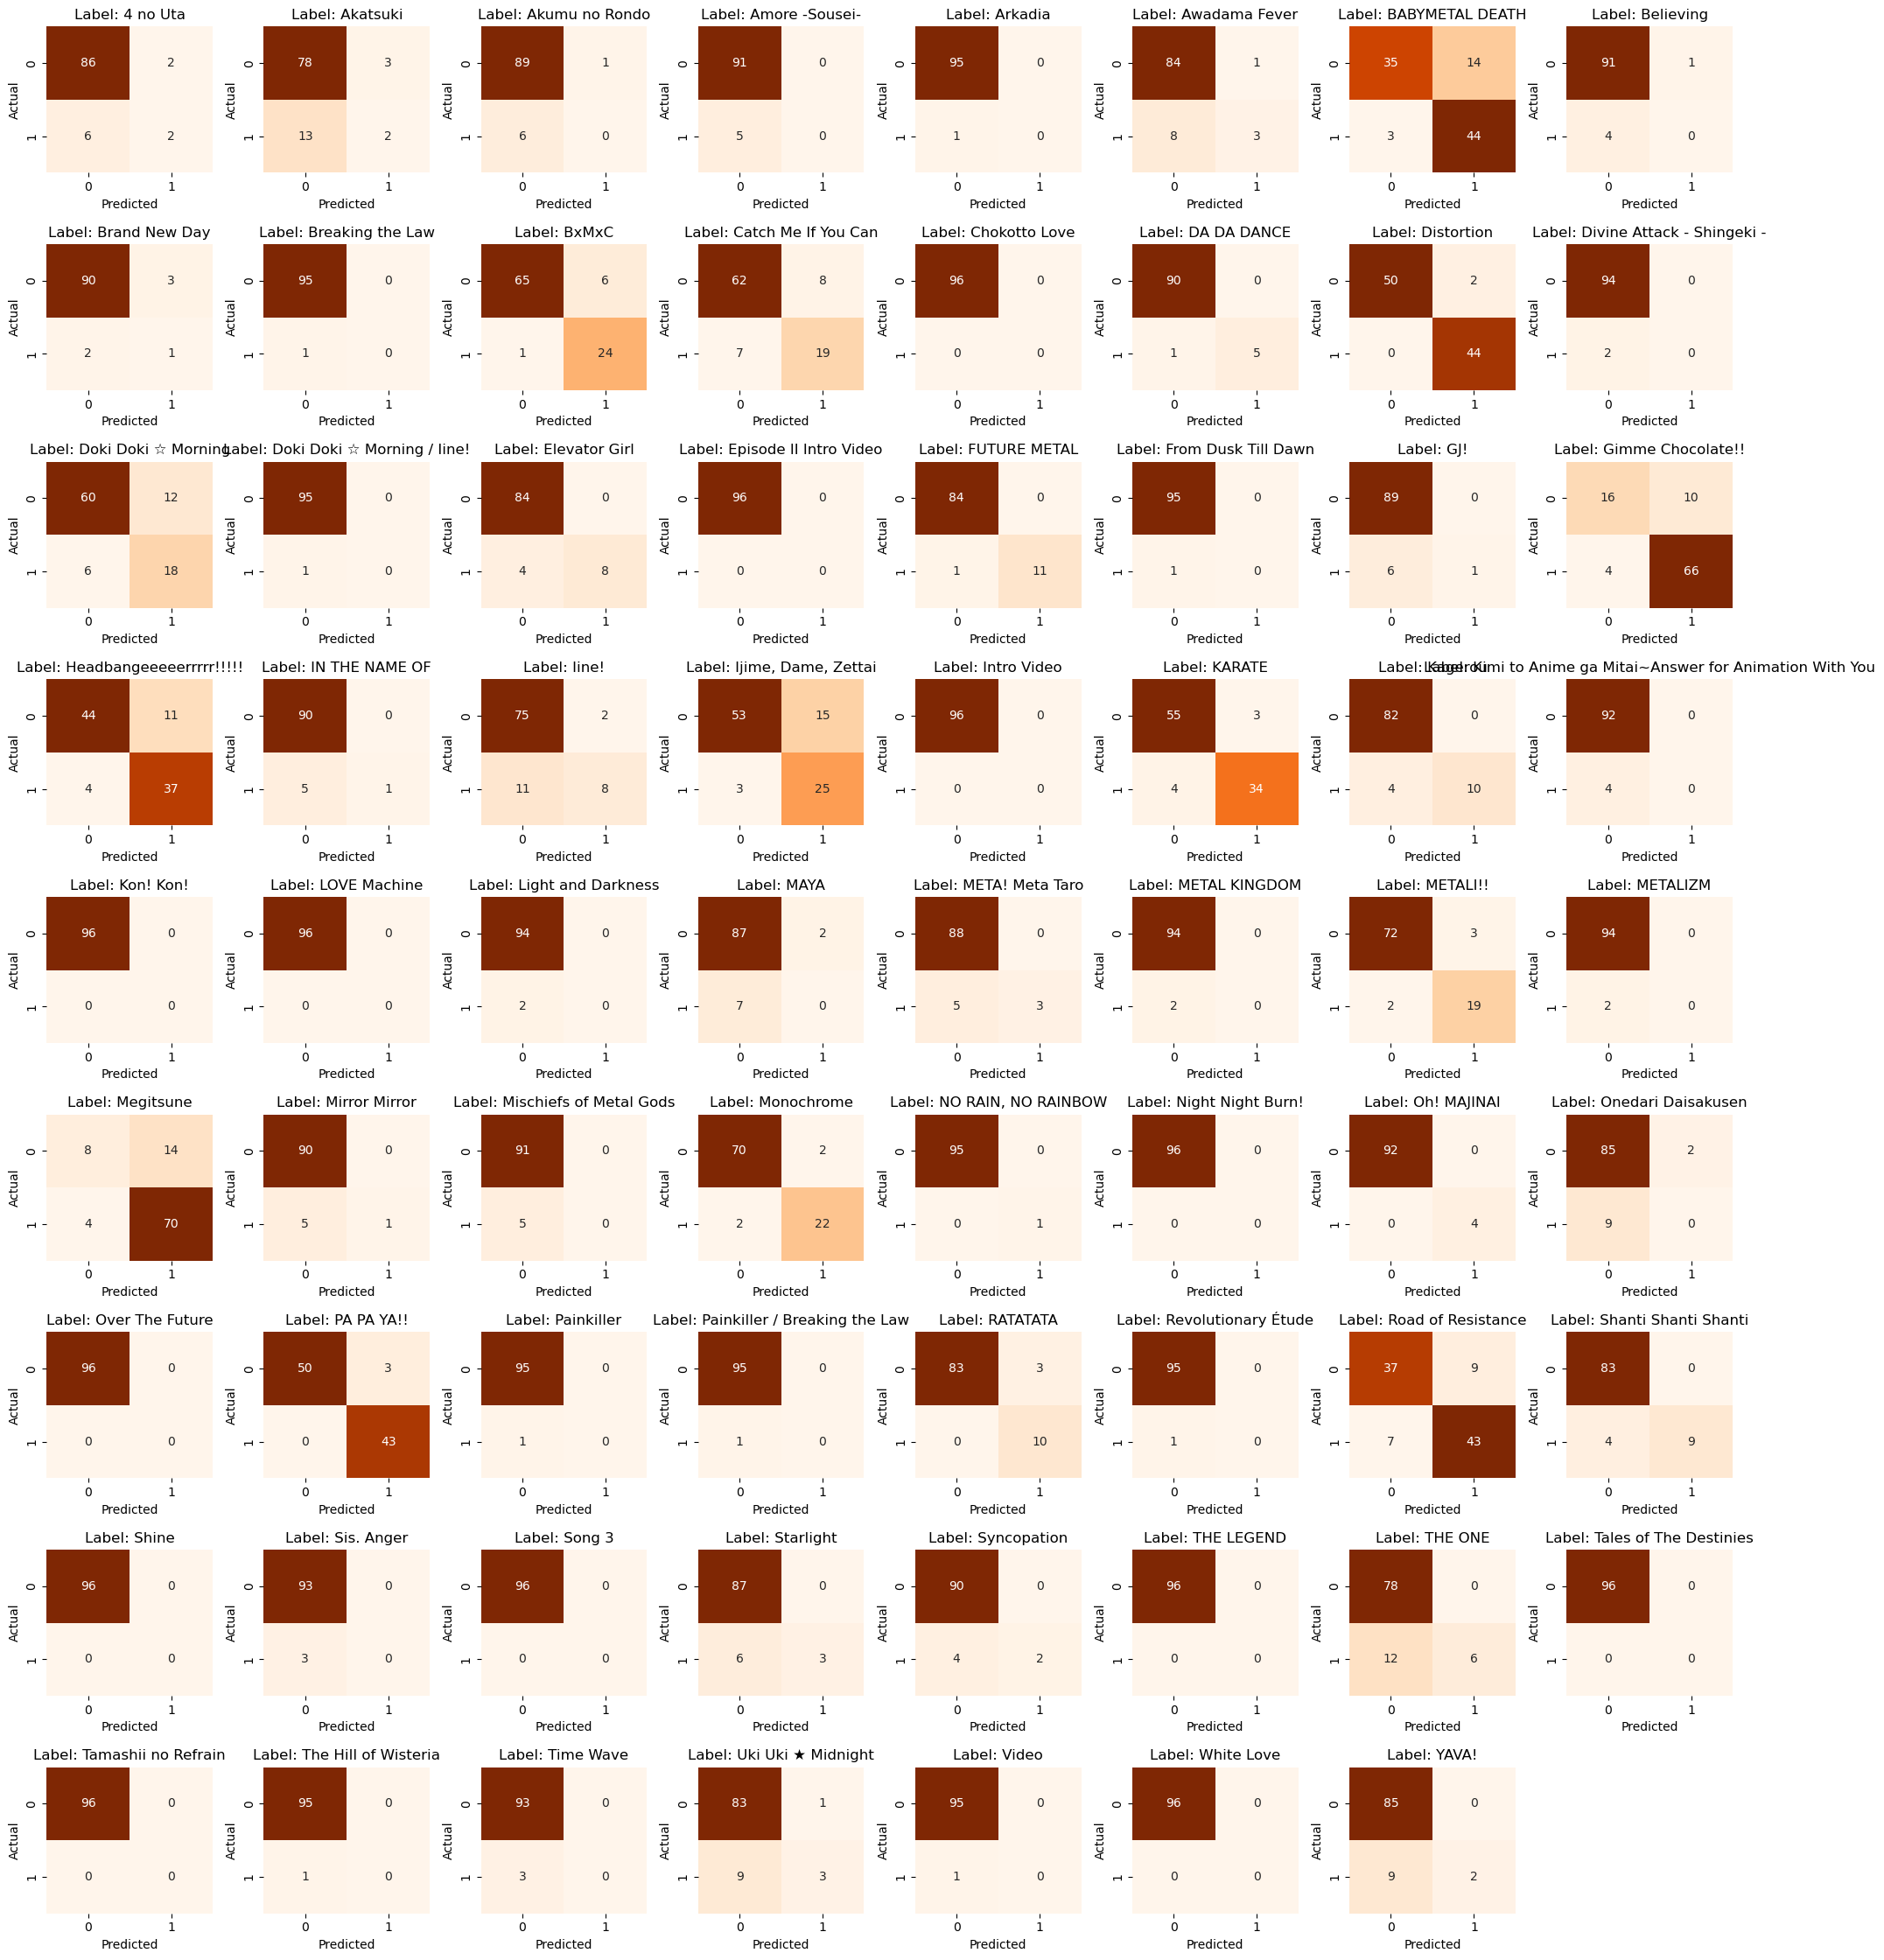

In [2093]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

y_pred = pipeline_base.predict(X_test)

# Generate multilabel confusion matrices
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

# Set up subplot grid: 9 rows x 8 columns = 72 subplots (you have 71 labels)
n_labels = y_test.shape[1]
n_cols = 8
n_rows = (n_labels + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 2.5 * n_rows))
axes = axes.flatten()

# Plot each confusion matrix
for i in range(n_labels):
    sns.heatmap(conf_matrix[i], annot=True, fmt='g', cmap='Oranges', ax=axes[i], cbar=False)
    axes[i].set_title(f"Label: {y_test.columns[i]}")
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Turn off unused subplots (if any)
for j in range(n_labels, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## **3.4. Adjusting Threshold**

We will try to adjust the threshold, but reminder for the final result we will use predict_proba, so the threshold not really be used in the end.

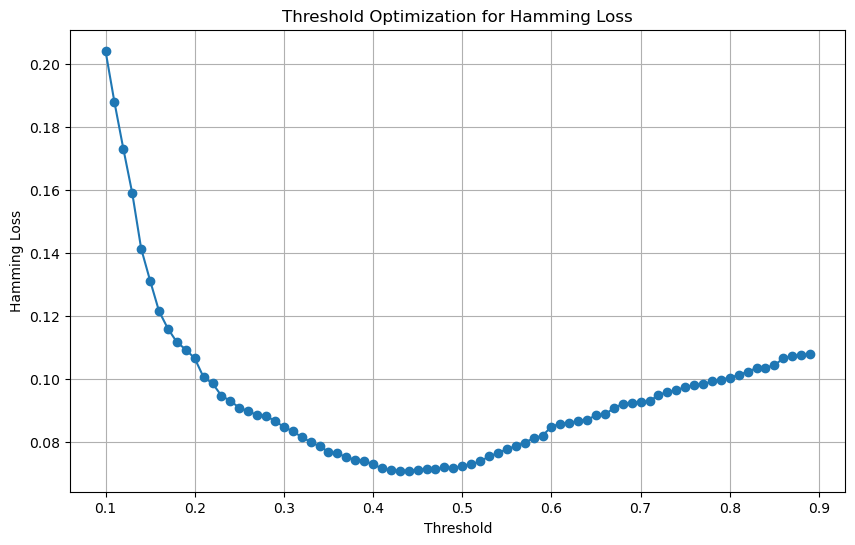


🔍 Best Threshold for Minimum Hamming Loss: 0.43

📊 Confusion Matrix (summed across all labels):
[[5823  164]
 [ 319  510]]

📄 Classification Report (micro-average):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00        11
           6       0.54      0.96      0.69        47
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         1
          10       0.81      0.88      0.85        25
          11       0.79      0.42      0.55        26
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         6
          14       0.96

In [2094]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import hamming_loss

# Assuming best_model is your fitted multilabel model (OneVsRestClassifier)
# and X_test, y_test are your test sets

# Get probabilities for each label (shape: n_samples x n_labels)
y_prob = best_model.predict_proba(X_test)  # multilabel probabilities

# Threshold range
thresholds = np.arange(0.1, 0.9, 0.01)

# Store average hamming losses for each threshold
hamming_losses = []

for threshold in thresholds:
    # Apply threshold to all labels
    y_pred = (y_prob >= threshold).astype(int)
    
    # Calculate hamming loss (lower is better)
    loss = hamming_loss(y_test, y_pred)
    hamming_losses.append(loss)

# Plot Hamming Loss vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, hamming_losses, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Hamming Loss')
plt.title('Threshold Optimization for Hamming Loss')
plt.grid(True)
plt.show()

# Get threshold with minimum hamming loss
best_threshold = thresholds[np.argmin(hamming_losses)]
print(f"\n🔍 Best Threshold for Minimum Hamming Loss: {best_threshold:.2f}")

# Predict with best threshold
y_pred_adjusted = (y_prob >= best_threshold).astype(int)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print("\n📊 Confusion Matrix (summed across all labels):")
print(confusion_matrix(y_test.values.ravel(), y_pred_adjusted.ravel()))

print("\n📄 Classification Report (micro-average):")
print(classification_report(y_test, y_pred_adjusted))


In [2095]:
best_model.fit(X_train, y_train)

y_pred_adjusted = (best_model.predict_proba(X_test)> best_threshold ).astype(int)
y_pred_adjusted

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## **3.4. Comparing Result**

In [2096]:
# Evaluation metrics for Best (Tuned) Model
f1_best = f1_score(y_test, y_pred_best, average='micro')
precision_best = precision_score(y_test, y_pred_best, average='micro', zero_division=0)
hamming_best = hamming_loss(y_test, y_pred_best)

# Evaluation metrics for Adjusted Model
f1_adjusted = f1_score(y_test, y_pred_adjusted, average='micro')
precision_adjusted = precision_score(y_test, y_pred_adjusted, average='micro', zero_division=0)
hamming_adjusted = hamming_loss(y_test, y_pred_adjusted)

# Print comparison
print("===== BASE MODEL =====")
print(f"F1 Score (micro): {f1_base:.6f}")
print(f"Precision (micro): {precision_base:.6f}")
print(f"Hamming Loss: {hamming_base:.6f}")

# Print comparison
print("\n===== BEST (TUNED) MODEL =====")
print(f"F1 Score (micro): {f1_best:.6f}")
print(f"Precision (micro): {precision_best:.6f}")
print(f"Hamming Loss: {hamming_best:.6f}")

print("\n===== Adjusted MODEL =====")
print(f"F1 Score (micro): {f1_adjusted:.6f}")
print(f"Precision (micro): {precision_adjusted:.6f}")
print(f"Hamming Loss: {hamming_adjusted:.6f}")

===== BASE MODEL =====
F1 Score (micro): 0.771392
Precision (micro): 0.819539
Hamming Loss: 0.052523

===== BEST (TUNED) MODEL =====
F1 Score (micro): 0.648649
Precision (micro): 0.790295
Hamming Loss: 0.072477

===== Adjusted MODEL =====
F1 Score (micro): 0.678643
Precision (micro): 0.756677
Hamming Loss: 0.070863


In [2097]:
# Create DataFrame: each column is a model's prediction, index = label names
selected_data_row = 0
df_pred = pd.DataFrame({
    'Test': y_test.iloc[selected_data_row].where(lambda x: x > 0).dropna(),
    'Base' : y_pred_base[selected_data_row],
    'Tuned': y_pred_best[selected_data_row],
    'Adjusted' : y_pred_adjusted[selected_data_row]

}, index=y.columns)
filtered_df_pred = df_pred[(df_pred['Test'] > 0) | (df_pred['Tuned'] > 0)| (df_pred['Adjusted'] > 0)]

filtered_df_pred

,Test,Base,Tuned,Adjusted
Doki Doki ☆ Morning,1.0,1,1,1
Iine!,1.0,0,0,0
"Ijime, Dame, Zettai",1.0,1,1,1


After we see the result, we will use the Base Model to predict because the score is better rather than the Tuned and Adjusted Model

## **3.5. Model Evaluation**

### Export the Model

In [2098]:
import pickle

# Save model

#fit
pipeline_base.fit(X, y)


filename = 'Prediction_Model.sav'

# save with pickle
pickle.dump(best_model, open(f'dataset/{filename}', 'wb'))

# Load model
loaded_model = pickle.load(open(f'dataset/{filename}', 'rb'))
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['venue', 'city', 'country']),
                                                 ('num', StandardScaler(),
                                                  ['month', 'year',
                                                   'days_since_new_album'])])),
                ('resampler', None),
                ('classifier',
                 OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                                      min_samples_leaf=2,
                                                                      random_state=42)))])

In [2099]:
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Feature Importance

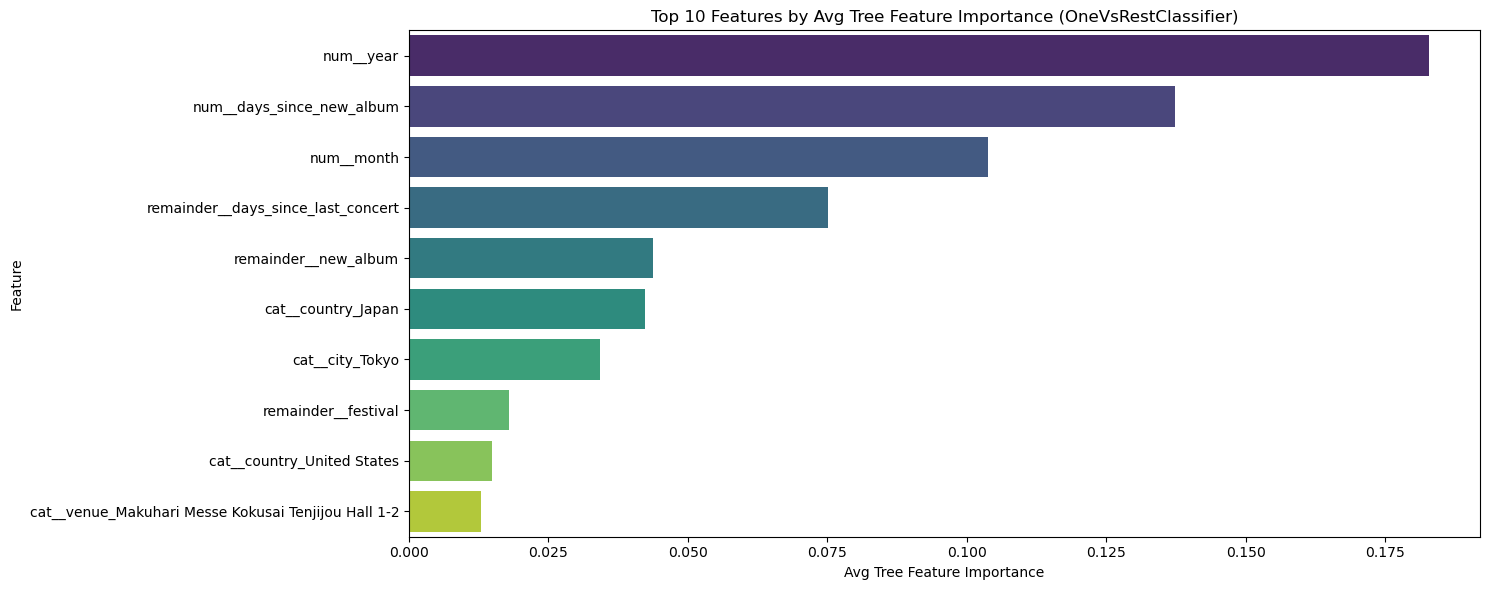

In [2176]:
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier

def plot_feature_importance(model_pipeline, X, y, top_n=10, random_state=42):
    """
    Fast approximate feature importance plotter.
    Skips permutation importance when not needed.
    Handles OneVsRest with dummy models gracefully.
    """

    try:
        feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
    except AttributeError:
        feature_names = np.array([f'Feature {i}' for i in range(X.shape[1])])

    model = model_pipeline.named_steps['classifier']

    # Case: model has direct feature_importances_
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        importance_type = "Tree Feature Importance"

    # Case: OneVsRest with multiple sub-models
    elif hasattr(model, 'estimators_'):
        # Filter out constant predictors
        valid_estimators = [
            est for est in model.estimators_
            if hasattr(est, 'feature_importances_') and not isinstance(est, DummyClassifier)
        ]

        if valid_estimators:
            importances = np.mean(
                [est.feature_importances_ for est in valid_estimators], axis=0
            )
            importance_type = "Avg Tree Feature Importance"
        else:
            print("⚠️ All estimators are constant predictors or non-informative. Skipping importance.")
            return

    # Fallback to permutation importance (slow)
    else:
        print("⚠️ Using permutation importance (slow). Consider simplifying the model for quick inspection.")
        X_transformed = model_pipeline.named_steps['preprocessor'].transform(X)
        if hasattr(X_transformed, "toarray"):
            X_transformed = X_transformed.toarray()
        result = permutation_importance(
            model, X_transformed, y,
            n_repeats=3,
            random_state=random_state
        )
        importances = result.importances_mean
        importance_type = "Permutation Importance"

    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances,
        'Importance_Type': importance_type
    }).sort_values('Importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(15, 6))
    sns.barplot(
        x='Importance',
        y='Feature',
        data=importance_df,
        palette='viridis'
    )
    plt.title(f'Top {top_n} Features by {importance_type} ({type(model).__name__})')
    plt.xlabel(importance_type)
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    return feature_names

# Usage example:
import joblib
pipeline = joblib.load("dataset/Prediction_Model.sav")
# Now pipeline should be fitted
evaluate = plot_feature_importance(pipeline, X_train, y_train, top_n=10)


### Inspect Tree

Here is the logic how the tree split, it take from 1 decision tree from 1 tree from 1 random tree

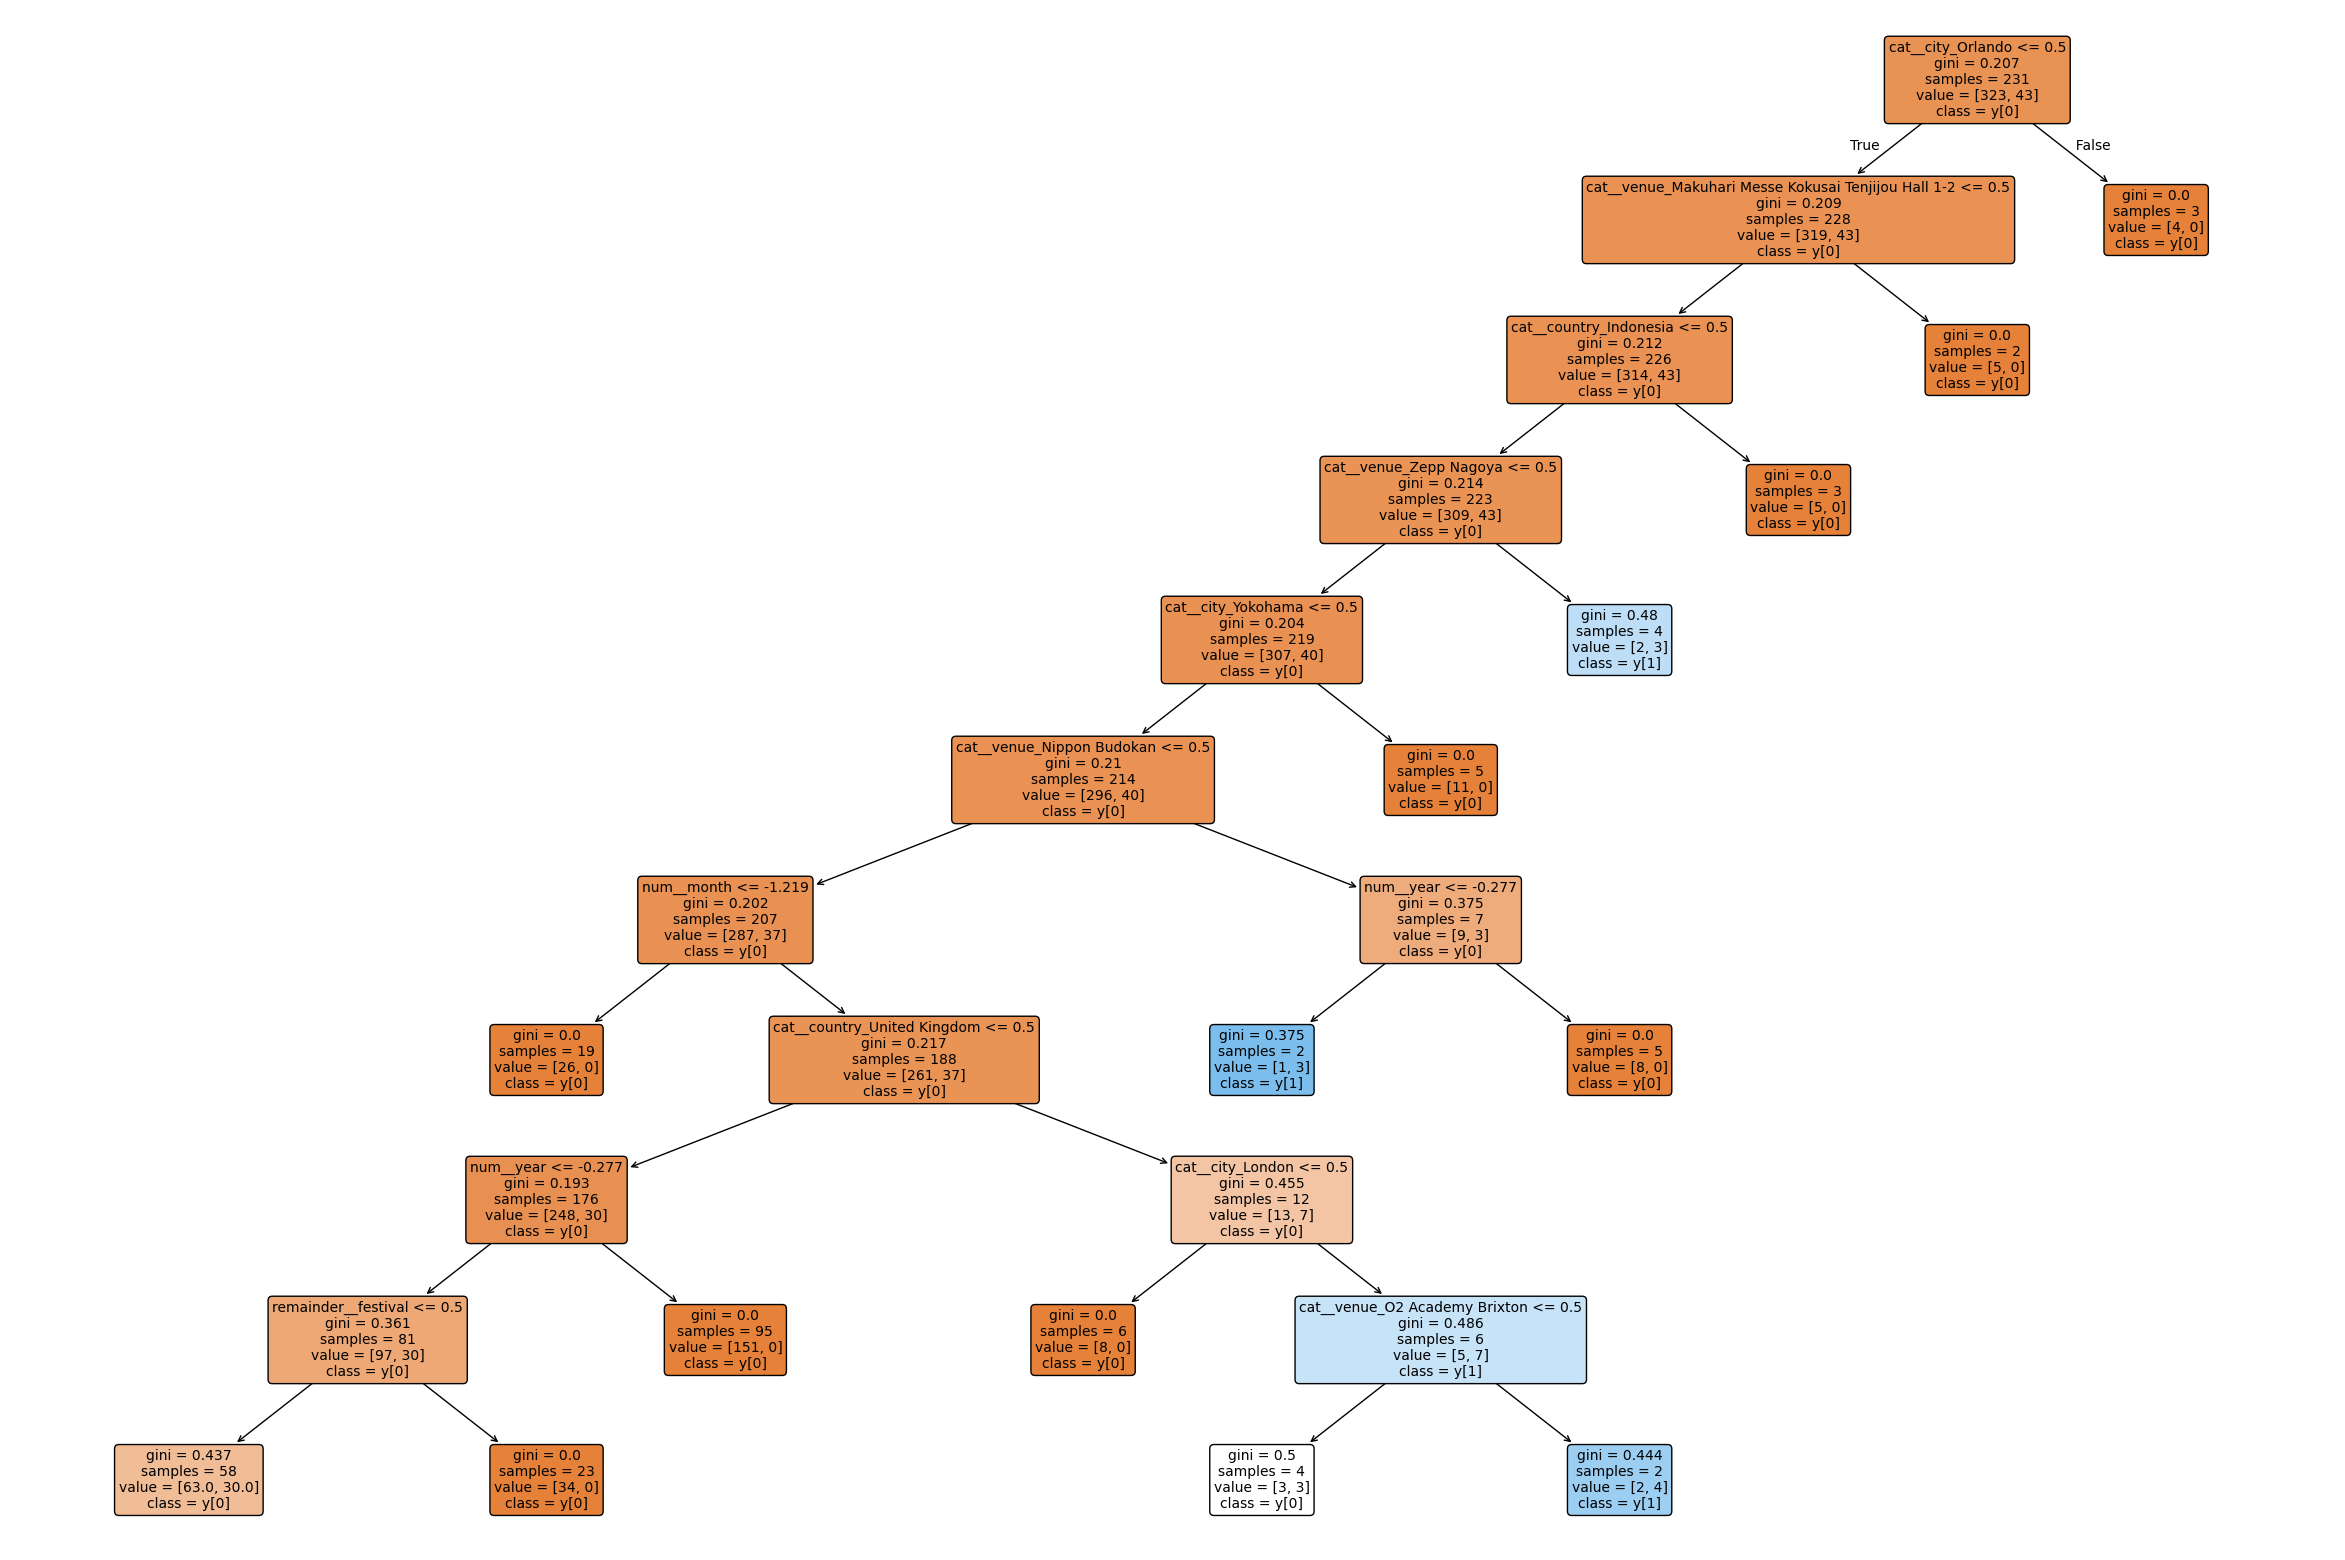

In [2101]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import joblib

# Load pipeline model
model = joblib.load("dataset/Prediction_Model.sav")

# Access OneVsRestClassifier
ovr = model.named_steps['classifier']

# Choose one random forest for one class (e.g., first one)
rf = ovr.estimators_[0]

# Choose one decision tree from the random forest (e.g., first tree)
tree = rf.estimators_[0]

# If you have your feature names ready (final_feature_names), add them below
plt.figure(figsize=(30,20))
plot_tree(
    tree,
    filled=True,
    rounded=True,
    feature_names=evaluate
,  # replace with your actual feature names list if available
    class_names=True,
    fontsize=10
)
plt.show()


## **3.6. Export the Model**

In [2102]:
import pickle

# Save model

#fit
pipeline_base.fit(X, y)


filename = 'Prediction_Model.sav'

# save with pickle
pickle.dump(best_model, open(f'dataset/{filename}', 'wb'))

# Load model
loaded_model = pickle.load(open(f'dataset/{filename}', 'rb'))
loaded_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['venue', 'city', 'country']),
                                                 ('num', StandardScaler(),
                                                  ['month', 'year',
                                                   'days_since_new_album'])])),
                ('resampler', None),
                ('classifier',
                 OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                                      min_samples_leaf=2,
                                                                      random_state=42)))])

## **3.7. Testing with New Data**

This will simulate a new data for prediction

In [ ]:
df_country_city = df.groupby('country')['city'].unique().reset_index()
df_city_venue = df.groupby('city')['venue'].unique().reset_index()


In [2149]:
random_data = []

for _ in range(5):
    countries = df_country_city['country']
    choosen_country = str(np.random.choice(countries, 1)[0])
    
    choosen_city = np.random.choice(
        df_country_city.loc[df_country_city['country'] == choosen_country, 'city'].values[0]
    )
    
    choosen_venue = np.random.choice(
        df_city_venue.loc[df_city_venue['city'] == choosen_city, 'venue'].values[0]
    )
    
    random_data.append({
        'country': choosen_country,
        'city': choosen_city,
        'venue': choosen_venue,
        'festival': np.random.choice([True, False], 1)[0],
        'days_since_last_concert': np.random.uniform(0, 100, 1).round(1)[0],
        'new_album': np.random.choice([True, False], 1)[0],
        'month': np.random.randint(1, 13, 1)[0],
        'year': np.random.choice([2024, 2021, 2027, 2030], 1)[0],
        'days_since_new_album': np.random.uniform(0, 40, 1).round(0)[0]
    })

random_data = pd.DataFrame(random_data)
random_data


,country,city,venue,festival,days_since_last_concert,new_album,month,year,days_since_new_album
0,Spain,Madrid,Palacio Vistalegre,False,1.2,False,4,2024,15.0
1,South Korea,Seoul,Gocheok Sky Dome,False,80.5,True,8,2021,13.0
2,Australia,Brisbane,Fortitude Music Hall,False,9.5,True,11,2024,16.0
3,France,Paris,Hippodrome de Longchamp,False,28.9,False,7,2027,38.0
4,Argentina,Buenos Aires,Parque de la Ciudad,False,51.3,True,1,2027,16.0


In [2106]:
y_pred = loaded_model.predict(random_data)
y_pred[0]
y_pred_proba = loaded_model.predict_proba(random_data)*100

rounded_y_pred_proba = np.round(y_pred_proba, 2)
rounded_y_pred_proba

array([[8.040e+00, 1.057e+01, 6.270e+00, 6.850e+00, 9.200e-01, 1.116e+01,
        6.262e+01, 3.150e+00, 3.170e+00, 0.000e+00, 3.202e+01, 1.737e+01,
        6.000e-02, 7.110e+00, 6.620e+01, 3.900e-01, 1.639e+01, 2.600e-01,
        1.747e+01, 4.600e-01, 1.787e+01, 1.240e+00, 7.450e+00, 9.300e+01,
        5.198e+01, 2.640e+00, 1.569e+01, 1.900e+01, 1.600e-01, 4.778e+01,
        1.691e+01, 8.500e-01, 1.000e-01, 6.000e-02, 1.060e+00, 8.950e+00,
        6.650e+00, 6.400e-01, 2.545e+01, 1.730e+00, 9.382e+01, 5.970e+00,
        3.670e+00, 2.276e+01, 1.720e+00, 1.830e+00, 5.080e+00, 6.520e+00,
        1.300e-01, 6.533e+01, 0.000e+00, 0.000e+00, 7.600e+00, 8.000e-02,
        6.125e+01, 2.433e+01, 7.300e-01, 2.850e+00, 1.000e-01, 1.353e+01,
        3.320e+00, 6.000e-02, 1.133e+01, 2.400e-01, 1.000e-01, 7.100e-01,
        1.680e+00, 7.390e+00, 0.000e+00, 1.300e-01, 8.700e+00],
       [9.100e+00, 1.033e+01, 6.960e+00, 7.440e+00, 8.300e-01, 1.156e+01,
        7.837e+01, 3.300e+00, 4.330e+00, 0.000e+

In [2148]:
selected = 2
display(random_data.iloc[[selected]])
predicted_song = pd.DataFrame(rounded_y_pred_proba[selected],index=df_target.columns).rename(columns={0:'Play'})
predicted_song = predicted_song[predicted_song['Play']>0].sort_values(by='Play',ascending=False).head(9)
predicted_song['Play'].apply(lambda x : str(x)+'%')

,country,city,venue,festival,days_since_last_concert,new_album,month,year,days_since_new_album
2,Japan,Kawasaki,CLUB CITTA',False,82.9,True,11,2024,38.0


Gimme Chocolate!!     85.09%
Megitsune             84.42%
BABYMETAL DEATH       75.54%
Distortion            58.05%
Road of Resistance    57.68%
PA PA YA!!            56.84%
BxMxC                 46.61%
KARATE                41.52%
Monochrome             40.3%
Name: Play, dtype: object

In [2150]:
new_song = pd.DataFrame({"Play":[100,100,100]},index=['from me to u' ,'Song 3','Kon! Kon!'])
pd.concat([new_song,predicted_song])

,Play
from me to u,100.00
Song 3,100.00
Kon! Kon!,100.00
Gimme Chocolate!!,85.09
Megitsune,84.42
BABYMETAL DEATH,75.54
Distortion,58.05
Road of Resistance,57.68
PA PA YA!!,56.84
BxMxC,46.61


# **Execute**

## Conclusion

We successfully create a multi label classification model with score :
- Precision (micro): 0.819
- Hamming Loss: 0.052

## **Streamlit**

I deploy the model to Streamlit, you can try it [here]('asdasd)

![Screenshot 2025-05-23 at 15.20.53.png](<attachment:Screenshot 2025-05-23 at 15.20.53.png>)
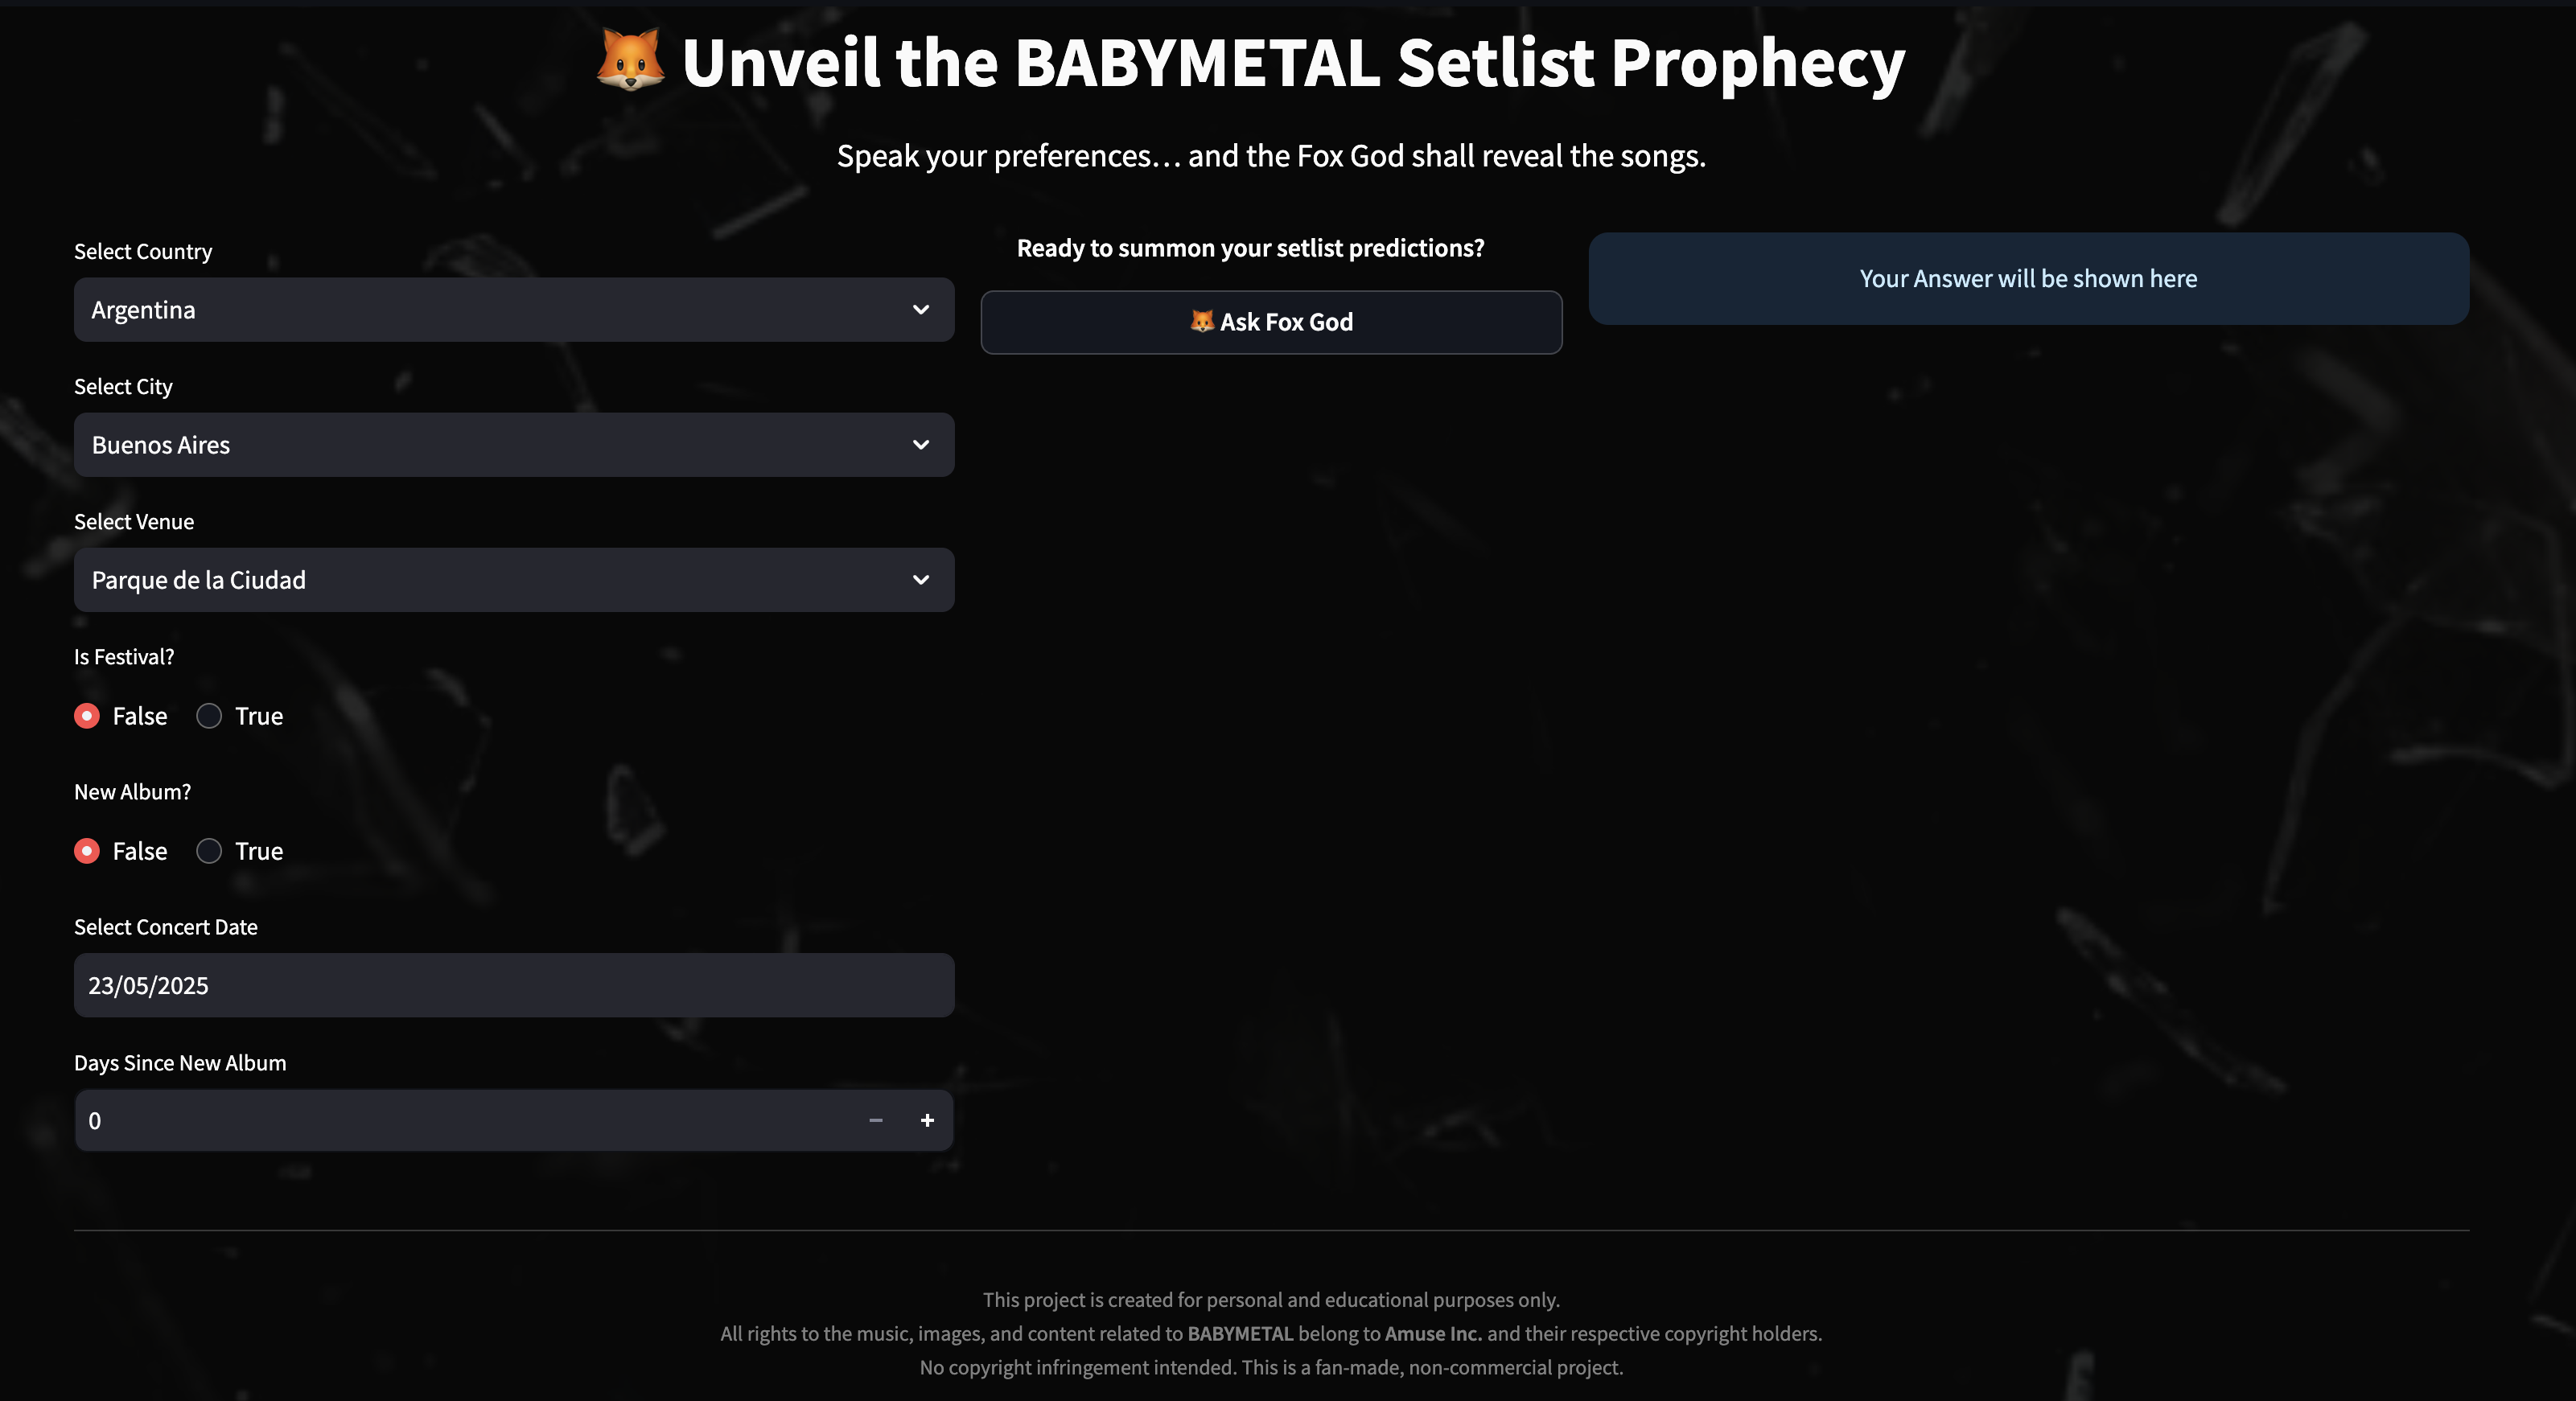

## **Dashboard**

![Dashboard 1.png](<attachment:Dashboard 1.png>)
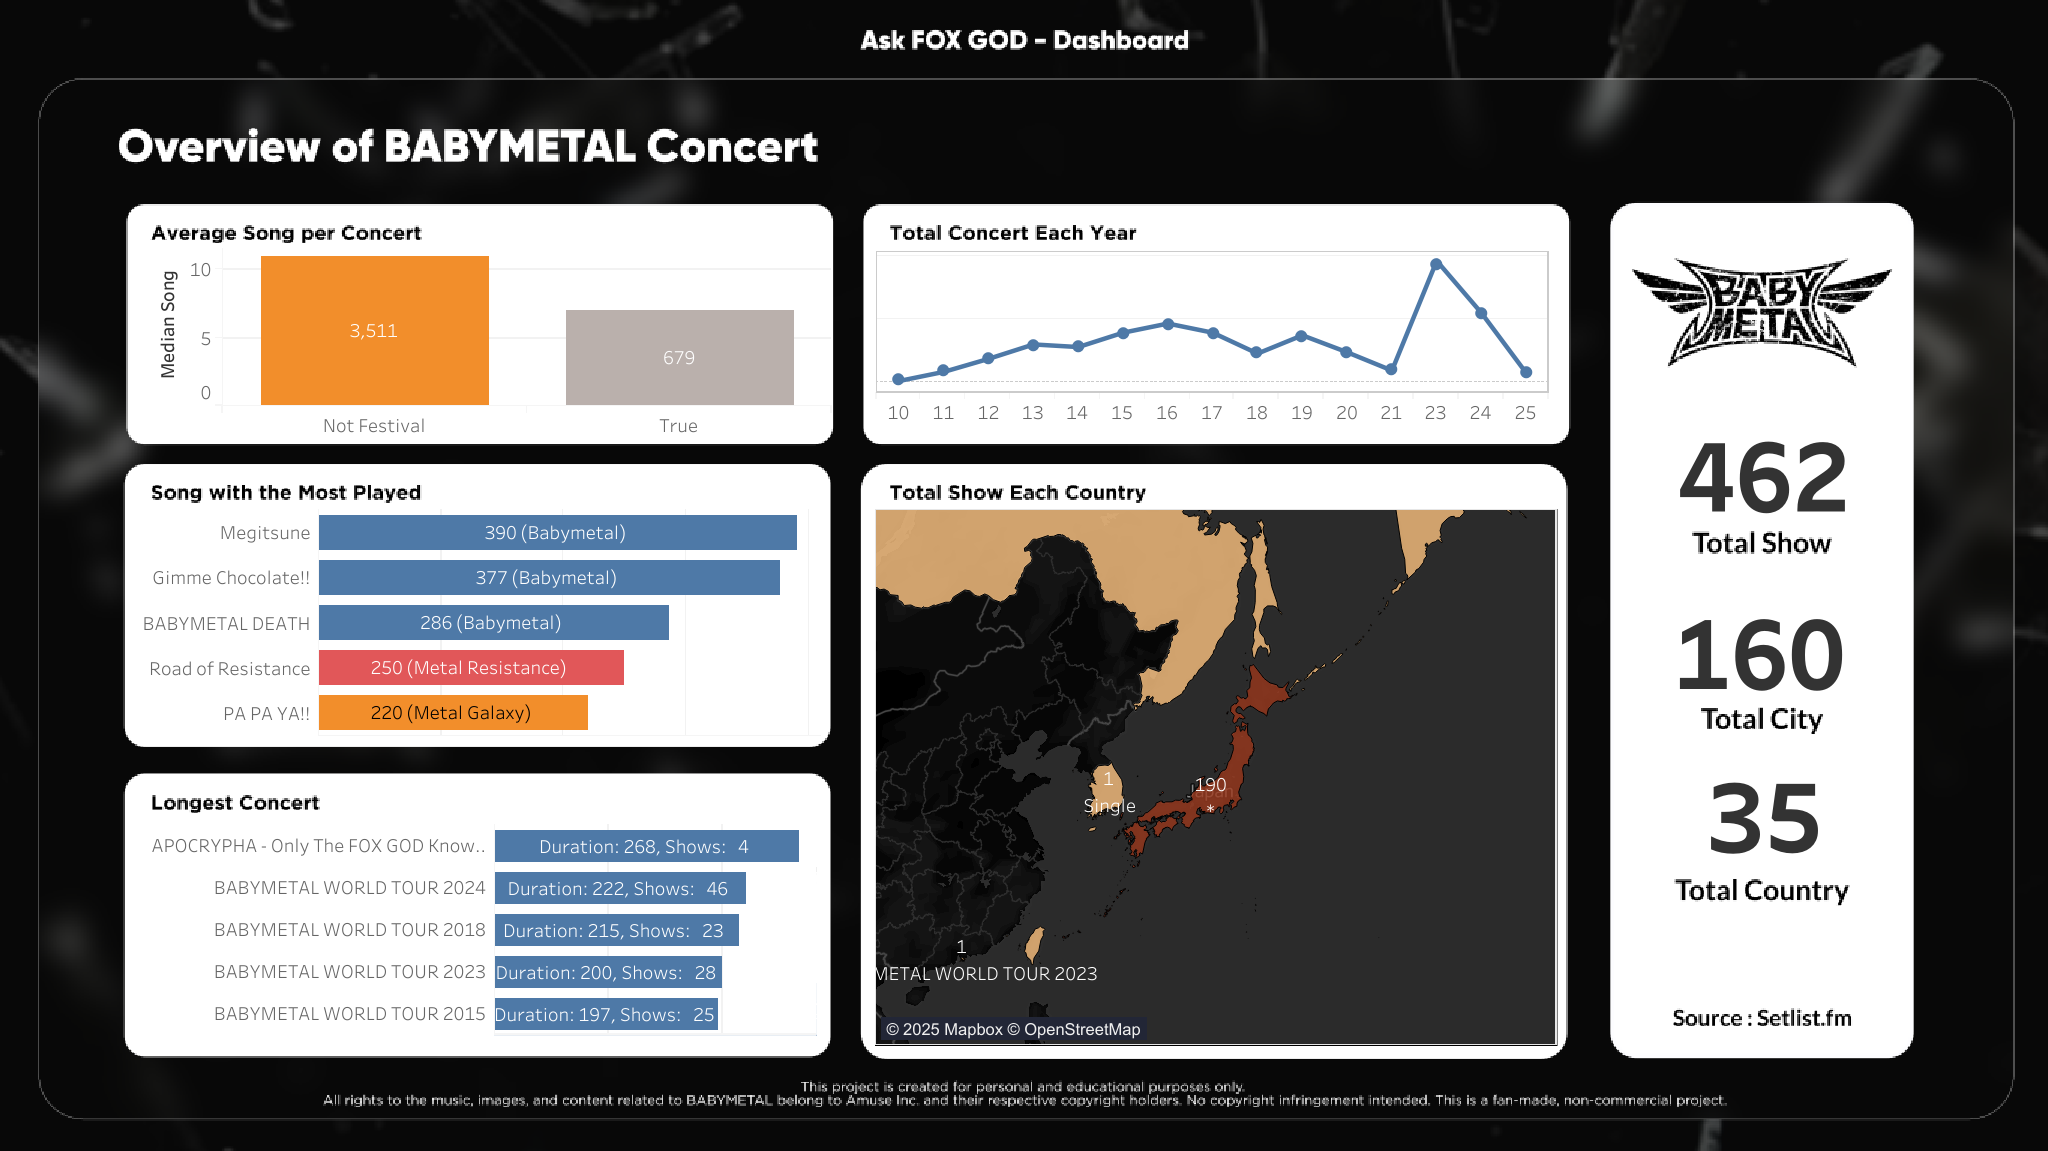